# Importing Necessary Libraries

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
pd.set_option("display.max_rows", None)


from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, GRU, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Bidirectional, GRU
from tensorflow.keras.layers import Bidirectional, SimpleRNN, Dense
from tensorflow.keras.layers import Dense, LSTM, Bidirectional


# Importing the Dataset


- Predictive maintenance on NASA's turbofan engine degradation dataset (CMAPSS). 
- Datasets include simulations of multiple turbofan engines over time, each row contains the following information:
  1. Engine unit number
  2. Time, in cycles
  3. Three operational settings
  4. 21 sensor readings.




In [2]:

# Define column names for easy indexing
index_names = ['unit_nr', 'time_cycles']
setting_names = ['Mach Number', 'Altitude', 'Sea-level temperature']
sensor_names = [
    "Fan inlet temperature (◦R)",
    "LPC outlet temperature (◦R)",
    "HPC outlet temperature (◦R)",
    "LPT outlet temperature (◦R)",
    "Fan inlet Pressure (psia)",
    "bypass-duct pressure (psia)",
    "HPC outlet pressure (psia)",
    "Physical fan speed (rpm)",
    "Physical core speed (rpm)",
    "Engine pressure ratio (P50/P2)",
    "HPC outlet Static pressure (psia)",
    "Ratio of fuel flow to Ps30 (pps/psia)",
    "Corrected fan speed (rpm)",
    "Corrected core speed (rpm)",
    "Bypass Ratio",
    "Burner fuel-air ratio",
    "Bleed Enthalpy",
    "Required fan speed",
    "Required fan conversion speed",
    "High-pressure turbines Cool air flow",
    "Low-pressure turbines Cool air flow"
]

col_names = index_names + setting_names + sensor_names

# Read data
train = pd.read_csv('train_FD004.txt', sep='\s+', header=None, names=col_names)
test = pd.read_csv('test_FD004.txt', sep='\s+', header=None, names=col_names)
y_test = pd.read_csv('RUL_FD004.txt', sep='\s+', header=None, names=['RUL'])

# Train data contains all features (Unit Number + setting parameters & sensor parameters)
# Test data contains all features (Unit Number + setting parameters & sensor parameters)
# Y_test contains RUL for the test data.
train.head()


unit_nr  time_cycles  Mach Number  Altitude  Sea-level temperature  \
0        1            1      42.0049    0.8400                  100.0   
1        1            2      20.0020    0.7002                  100.0   
2        1            3      42.0038    0.8409                  100.0   
3        1            4      42.0000    0.8400                  100.0   
4        1            5      25.0063    0.6207                   60.0   

   Fan inlet temperature (◦R)  LPC outlet temperature (◦R)  \
0                      445.00                       549.68   
1                      491.19                       606.07   
2                      445.00                       548.95   
3                      445.00                       548.70   
4                      462.54                       536.10   

   HPC outlet temperature (◦R)  LPT outlet temperature (◦R)  \
0                      1343.43                      1112.93   
1                      1477.61                      1237.50   
2                      1343.12                      1117.05   
3                      1341.24                      1118.03   
4                      1255.23                      1033.59   

   Fan inlet Pressure (psia)  ...  Ratio of fuel flow to Ps30 (pps/psia)  \
0                       3.91  ...                                 129.78   
1                       9.35  ...                                 312.59   
2                       3.91  ...                                 129.62   
3                       3.91  ...                                 129.80   
4                       7.05  ...                                 164.11   

   Corrected fan speed (rpm)  Corrected core speed (rpm)  Bypass Ratio  \
0                    2387.99                     8074.83        9.3335   
1                    2387.73                     8046.13        9.1913   
2                    2387.97                     8066.62        9.4007   
3                    2388.02                     8076.05        9.3369   
4                    2028.08                     7865.80       10.8366   

   Burner fuel-air ratio  Bleed Enthalpy  Required fan speed  \
0                   0.02             330                2212   
1                   0.02             361                2324   
2                   0.02             329                2212   
3                   0.02             328                2212   
4                   0.02             305                1915   

   Required fan conversion speed  High-pressure turbines Cool air flow  \
0                         100.00                                 10.62   
1                         100.00                                 24.37   
2                         100.00                                 10.48   
3                         100.00                                 10.54   
4                          84.93                                 14.03   

   Low-pressure turbines Cool air flow  
0                               6.3670  
1                              14.6552  
2                               6.4213  
3                               6.4176  
4                               8.6754  

[5 rows x 26 columns]

In [3]:
test.head()

unit_nr  time_cycles  Mach Number  Altitude  Sea-level temperature  \
0        1            1      20.0072    0.7000                  100.0   
1        1            2      24.9984    0.6200                   60.0   
2        1            3      42.0000    0.8420                  100.0   
3        1            4      42.0035    0.8402                  100.0   
4        1            5      35.0079    0.8400                  100.0   

   Fan inlet temperature (◦R)  LPC outlet temperature (◦R)  \
0                      491.19                       606.67   
1                      462.54                       536.22   
2                      445.00                       549.23   
3                      445.00                       549.19   
4                      449.44                       555.10   

   HPC outlet temperature (◦R)  LPT outlet temperature (◦R)  \
0                      1481.04                      1227.81   
1                      1256.17                      1031.48   
2                      1340.13                      1105.88   
3                      1339.70                      1107.26   
4                      1353.04                      1117.80   

   Fan inlet Pressure (psia)  ...  Ratio of fuel flow to Ps30 (pps/psia)  \
0                       9.35  ...                                 313.03   
1                       7.05  ...                                 163.61   
2                       3.91  ...                                 129.98   
3                       3.91  ...                                 129.48   
4                       5.48  ...                                 181.82   

   Corrected fan speed (rpm)  Corrected core speed (rpm)  Bypass Ratio  \
0                    2387.78                     8048.98        9.2229   
1                    2028.09                     7863.46       10.8632   
2                    2387.95                     8071.13        9.3960   
3                    2387.90                     8078.89        9.3594   
4                    2387.87                     8057.83        9.3030   

   Burner fuel-air ratio  Bleed Enthalpy  Required fan speed  \
0                   0.02             362                2324   
1                   0.02             306                1915   
2                   0.02             328                2212   
3                   0.02             328                2212   
4                   0.02             333                2223   

   Required fan conversion speed  High-pressure turbines Cool air flow  \
0                         100.00                                 24.31   
1                          84.93                                 14.36   
2                         100.00                                 10.39   
3                         100.00                                 10.56   
4                         100.00                                 14.85   

   Low-pressure turbines Cool air flow  
0                              14.7007  
1                               8.5748  
2                               6.4365  
3                               6.2367  
4                               8.9326  

[5 rows x 26 columns]

In [4]:
y_test.head()

RUL
0   22
1   39
2  107
3   75
4  149

In [5]:
train.shape

(61249, 26)

In [6]:
y_test.shape

(248, 1)

In [7]:
train['unit_nr'].unique()

# There are 100 no unique engines.

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

Note:  for Test Dataset Since the true RUL values for the test set are only provided for the last time cycle of each enginge, 
therefore the test dataset will be subsetted to represent the same.

In [8]:
test.shape

(41214, 26)

In [9]:
# Since the true RUL values (y_test) for the test set are only provided for the last time cycle of each enginge, 
# the test set is subsetted to represent the same

test = test.groupby('unit_nr').last().reset_index().drop(['unit_nr','time_cycles'], axis=1)


In [10]:
y_test.shape

# RUL value for 100 no of engines.

(248, 1)

In [11]:
test.shape
# Now test data contains entries for 100 no of engines with their RUL.

(248, 24)

# Data Pre-Processing + Data Visualization

In [12]:
train.describe()

unit_nr   time_cycles   Mach Number      Altitude  \
count  61249.000000  61249.000000  61249.000000  61249.000000   
mean     124.325181    134.311417     23.999823      0.571347   
std       71.995350     89.783389     14.780722      0.310703   
min        1.000000      1.000000      0.000000      0.000000   
25%       60.000000     62.000000     10.004600      0.250700   
50%      126.000000    123.000000     25.001400      0.700000   
75%      185.000000    191.000000     41.998100      0.840000   
max      249.000000    543.000000     42.008000      0.842000   

       Sea-level temperature  Fan inlet temperature (◦R)  \
count           61249.000000                61249.000000   
mean               94.031576                  472.882435   
std                14.251954                   26.436832   
min                60.000000                  445.000000   
25%               100.000000                  445.000000   
50%               100.000000                  462.540000   
75%               100.000000                  491.190000   
max               100.000000                  518.670000   

       LPC outlet temperature (◦R)  HPC outlet temperature (◦R)  \
count                 61249.000000                 61249.000000   
mean                    579.420056                  1417.896600   
std                      37.342647                   106.167598   
min                     535.480000                  1242.670000   
25%                     549.330000                  1350.550000   
50%                     555.740000                  1367.680000   
75%                     607.070000                  1497.420000   
max                     644.420000                  1613.000000   

       LPT outlet temperature (◦R)  Fan inlet Pressure (psia)  ...  \
count                 61249.000000               61249.000000  ...   
mean                   1201.915359                   8.031626  ...   
std                     119.327591                   3.622872  ...   
min                    1024.420000                   3.910000  ...   
25%                    1119.490000                   3.910000  ...   
50%                    1136.920000                   7.050000  ...   
75%                    1302.620000                  10.520000  ...   
max                    1440.770000                  14.620000  ...   

       Ratio of fuel flow to Ps30 (pps/psia)  Corrected fan speed (rpm)  \
count                           61249.000000               61249.000000   
mean                              266.735665                2334.427590   
std                               138.479109                 128.197859   
min                               128.310000                2027.570000   
25%                               134.520000                2387.910000   
50%                               183.450000                2388.060000   
75%                               371.400000                2388.170000   
max                               537.490000                2390.490000   

       Corrected core speed (rpm)  Bypass Ratio  Burner fuel-air ratio  \
count                61249.000000  61249.000000           61249.000000   
mean                  8067.811812      9.285604               0.023252   
std                     85.670543      0.750374               0.004685   
min                   7845.780000      8.175700               0.020000   
25%                   8062.630000      8.648000               0.020000   
50%                   8083.810000      9.255600               0.020000   
75%                   8128.350000      9.365800               0.030000   
max                   8261.650000     11.066300               0.030000   

       Bleed Enthalpy  Required fan speed  Required fan conversion speed  \
count    61249.000000        61249.000000                   61249.000000   
mean       347.760029         2228.613283                      97.751396   
std         27.808283          145.472491                       5.369424   
min

In [13]:
# Adding RUL (Ramining Useful Life) to the train dataset

In [14]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train)
train[sensor_names+['RUL']].head()

Fan inlet temperature (◦R)  LPC outlet temperature (◦R)  \
0                      445.00                       549.68   
1                      491.19                       606.07   
2                      445.00                       548.95   
3                      445.00                       548.70   
4                      462.54                       536.10   

   HPC outlet temperature (◦R)  LPT outlet temperature (◦R)  \
0                      1343.43                      1112.93   
1                      1477.61                      1237.50   
2                      1343.12                      1117.05   
3                      1341.24                      1118.03   
4                      1255.23                      1033.59   

   Fan inlet Pressure (psia)  bypass-duct pressure (psia)  \
0                       3.91                         5.70   
1                       9.35                        13.61   
2                       3.91                         5.69   
3                       3.91                         5.70   
4                       7.05                         9.00   

   HPC outlet pressure (psia)  Physical fan speed (rpm)  \
0                      137.36                   2211.86   
1                      332.10                   2323.66   
2                      138.18                   2211.92   
3                      137.98                   2211.88   
4                      174.82                   1915.22   

   Physical core speed (rpm)  Engine pressure ratio (P50/P2)  ...  \
0                    8311.32                            1.01  ...   
1                    8713.60                            1.07  ...   
2                    8306.69                            1.01  ...   
3                    8312.35                            1.02  ...   
4                    7994.94                            0.93  ...   

   Corrected fan speed (rpm)  Corrected core speed (rpm)  Bypass Ratio  \
0                    2387.99                     8074.83        9.3335   
1                    2387.73                     8046.13        9.1913   
2                    2387.97                     8066.62        9.4007   
3                    2388.02                     8076.05        9.3369   
4                    2028.08                     7865.80       10.8366   

   Burner fuel-air ratio  Bleed Enthalpy  Required fan speed  \
0                   0.02             330                2212   
1                   0.02             361                2324   
2                   0.02             329                2212   
3                   0.02             328                2212   
4                   0.02             305                1915   

   Required fan conversion speed  High-pressure turbines Cool air flow  \
0                         100.00                                 10.62   
1                         100.00                                 24.37   
2                         100.00                                 10.48   
3                         100.00                                 10.54   
4                          84.93                                 14.03   

   Low-pressure turbines Cool air flow  RUL  
0                               6.3670  320  
1                              14.6552  319  
2                               6.4213  318  
3                               6.4176  317  
4                               8.6754  316  

[5 rows x 22 columns]

In [15]:
train.head(5)

unit_nr  time_cycles  Mach Number  Altitude  Sea-level temperature  \
0        1            1      42.0049    0.8400                  100.0   
1        1            2      20.0020    0.7002                  100.0   
2        1            3      42.0038    0.8409                  100.0   
3        1            4      42.0000    0.8400                  100.0   
4        1            5      25.0063    0.6207                   60.0   

   Fan inlet temperature (◦R)  LPC outlet temperature (◦R)  \
0                      445.00                       549.68   
1                      491.19                       606.07   
2                      445.00                       548.95   
3                      445.00                       548.70   
4                      462.54                       536.10   

   HPC outlet temperature (◦R)  LPT outlet temperature (◦R)  \
0                      1343.43                      1112.93   
1                      1477.61                      1237.50   
2                      1343.12                      1117.05   
3                      1341.24                      1118.03   
4                      1255.23                      1033.59   

   Fan inlet Pressure (psia)  ...  Corrected fan speed (rpm)  \
0                       3.91  ...                    2387.99   
1                       9.35  ...                    2387.73   
2                       3.91  ...                    2387.97   
3                       3.91  ...                    2388.02   
4                       7.05  ...                    2028.08   

   Corrected core speed (rpm)  Bypass Ratio  Burner fuel-air ratio  \
0                     8074.83        9.3335                   0.02   
1                     8046.13        9.1913                   0.02   
2                     8066.62        9.4007                   0.02   
3                     8076.05        9.3369                   0.02   
4                     7865.80       10.8366                   0.02   

   Bleed Enthalpy  Required fan speed  Required fan conversion speed  \
0             330                2212                         100.00   
1             361                2324                         100.00   
2             329                2212                         100.00   
3             328                2212                         100.00   
4             305                1915                          84.93   

   High-pressure turbines Cool air flow  Low-pressure turbines Cool air flow  \
0                                 10.62                               6.3670   
1                                 24.37                              14.6552   
2                                 10.48                               6.4213   
3                                 10.54                               6.4176   
4                                 14.03                               8.6754   

   RUL  
0  320  
1  319  
2  318  
3  317  
4  316  

[5 rows x 27 columns]

## Plotting of RUL

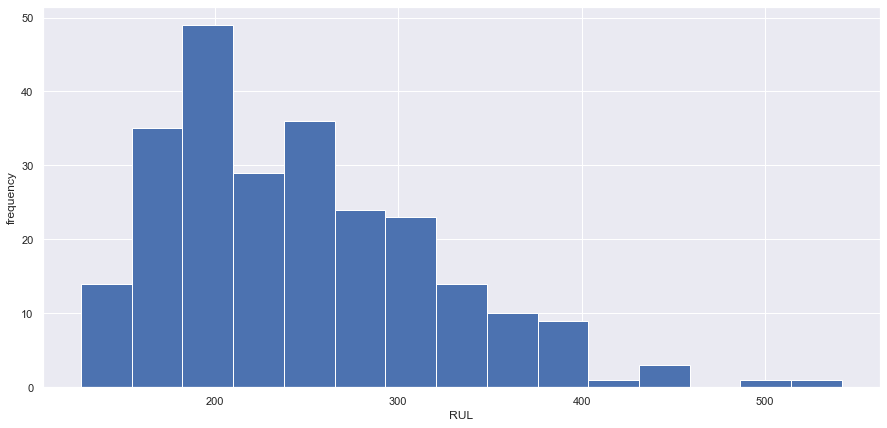

In [16]:
# distribution of RUL, similar to the 'describe function' of time_cycles above, but visual
df_max_rul = train[['unit_nr', 'RUL']].groupby('unit_nr').max().reset_index()
df_max_rul['RUL'].hist(bins=15, figsize=(15,7))
plt.xlabel('RUL')
plt.ylabel('frequency')
plt.show()

In [17]:
# We can see the RUL for engine is bit skewed on left side. This may affect perfomance of the model however as of now we will keep it as it.


## Plotting of Sensor Values Vs RUL

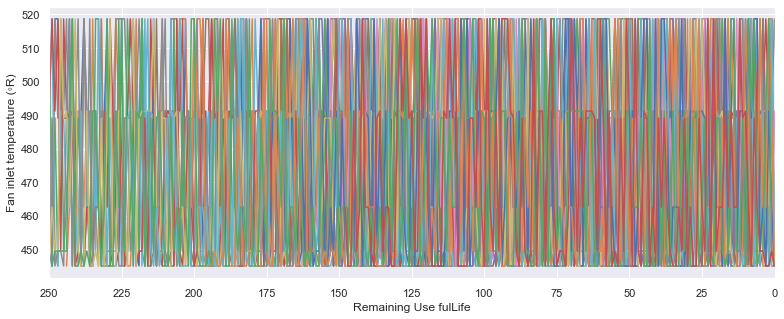

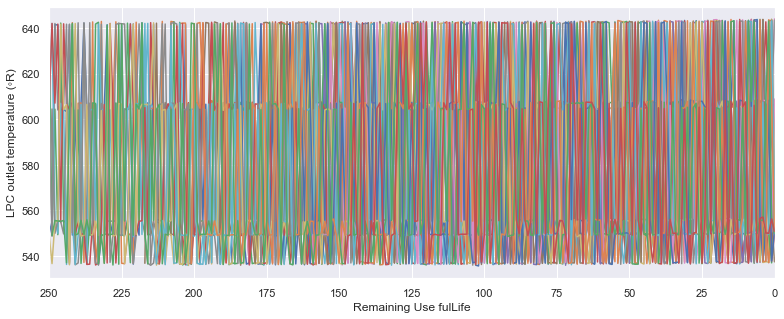

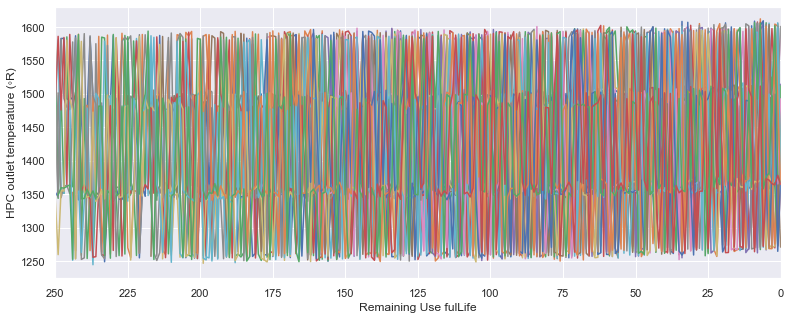

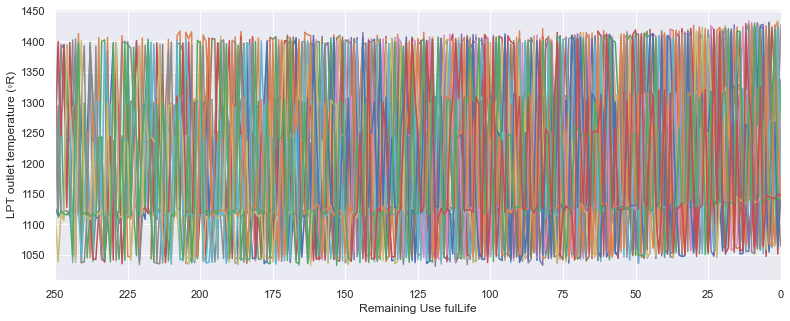

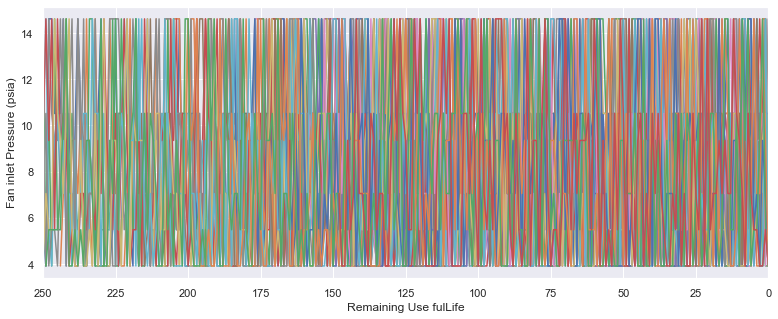

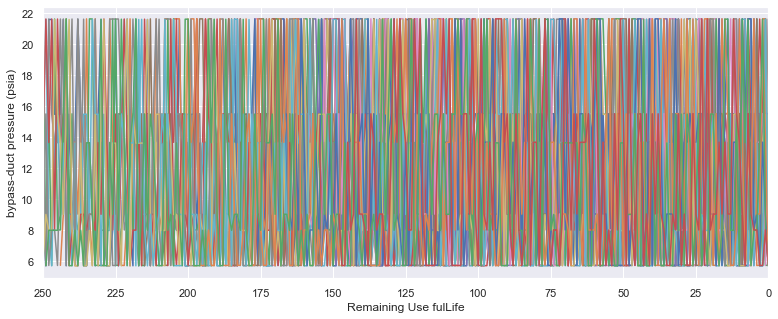

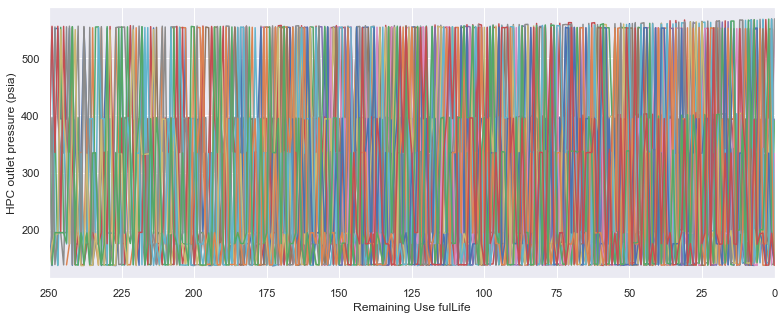

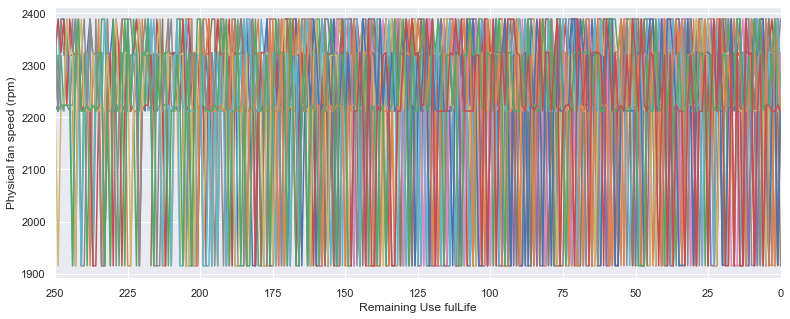

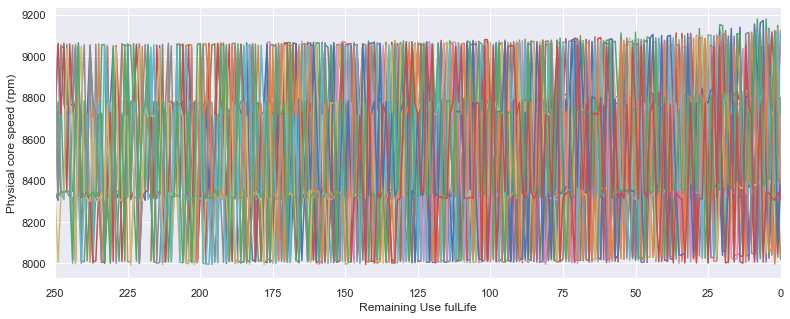

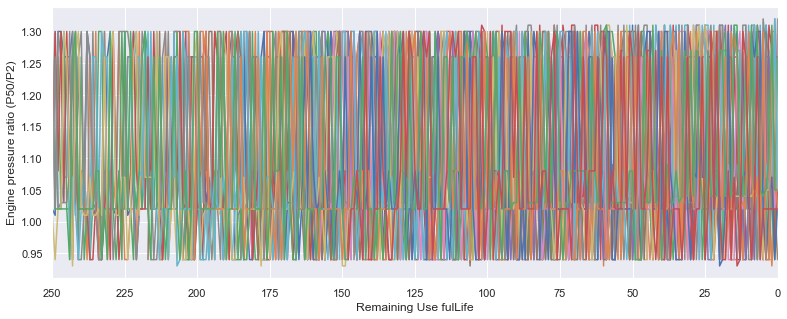

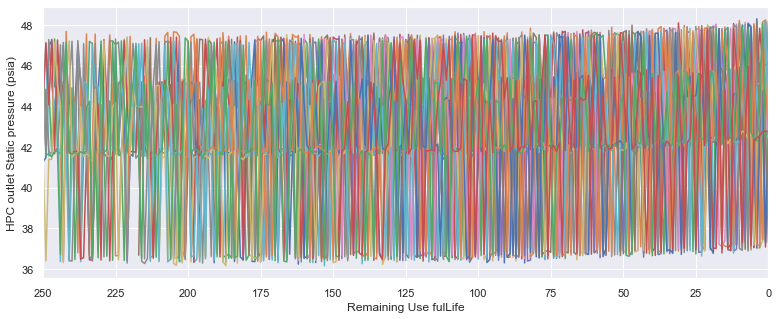

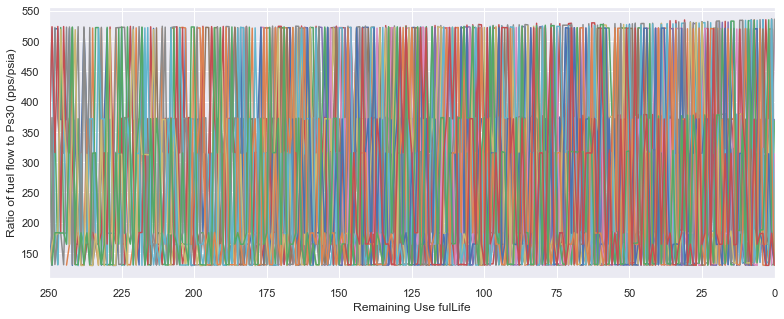

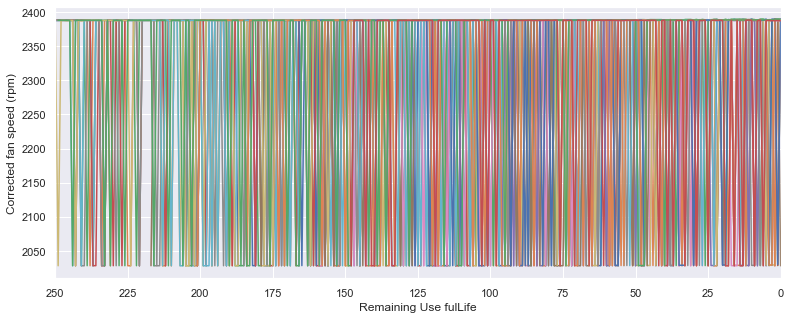

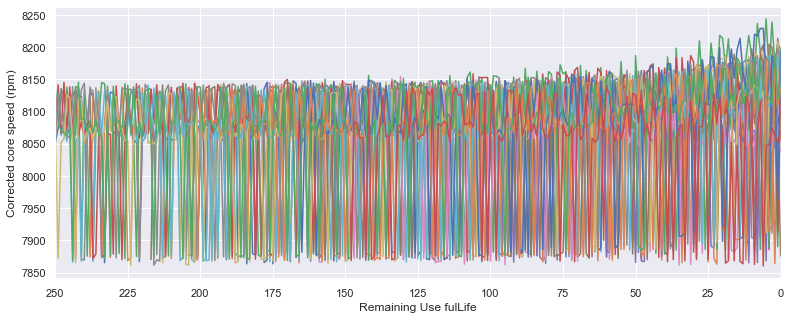

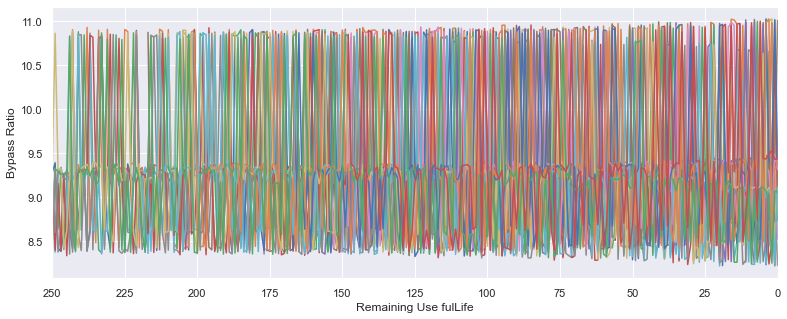

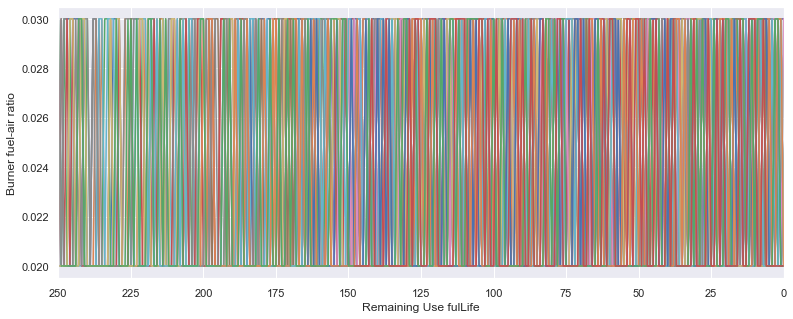

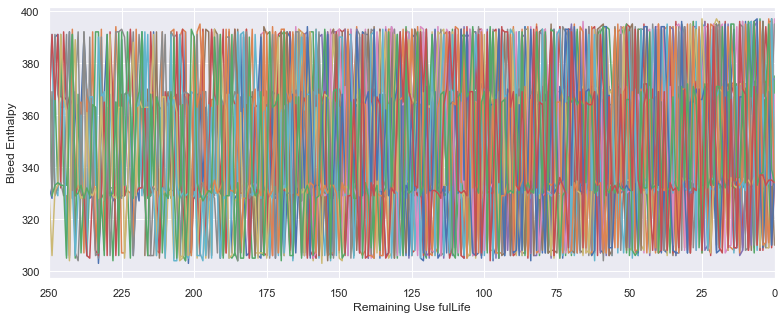

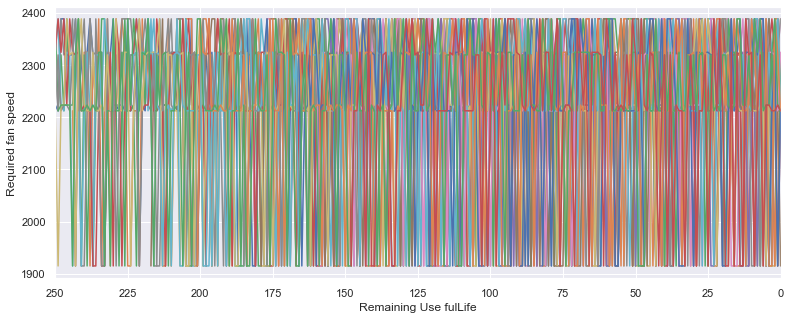

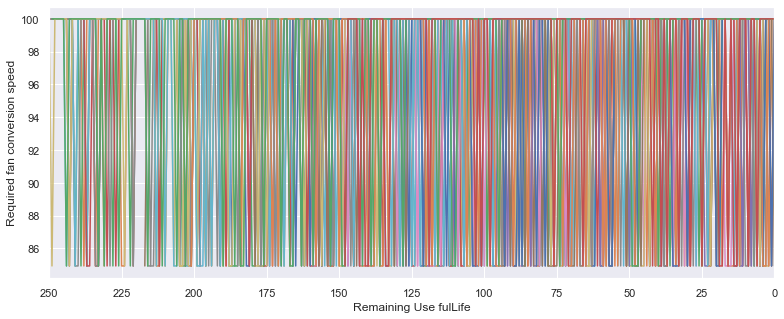

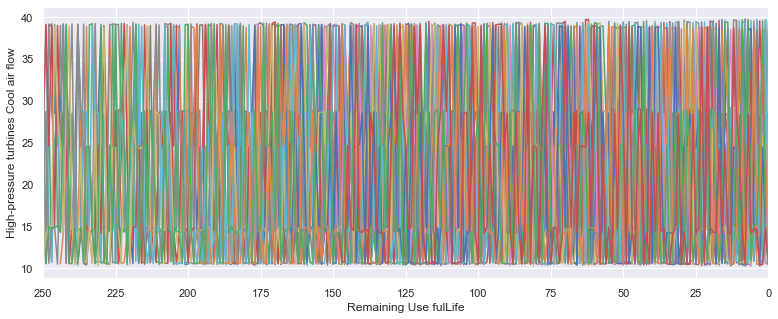

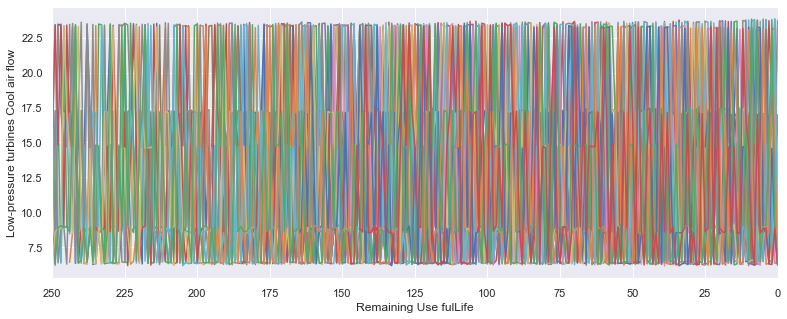

In [18]:
def plot_sensor(sensor_name):
    plt.figure(figsize=(13,5))
    for i in train['unit_nr'].unique():
        if (i % 10 == 0):  # only plot every 10th unit_nr
            plt.plot('RUL', sensor_name, 
                     data=train[train['unit_nr']==i])
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(sensor_name)
    plt.xlabel('Remaining Use fulLife')
    plt.show()

for sensor_name in sensor_names:
    plot_sensor(sensor_name)

- Based on the plots you can see all sensors hold information related to Remaining Useful Life.
- As on now we will keep all features and will remove non-important features after calculating correlation value of each sensor variable with the RUL.

## Boxplots to find outliers

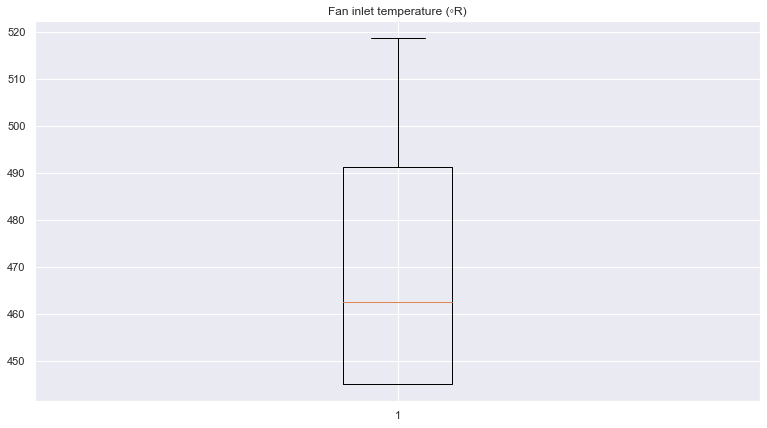

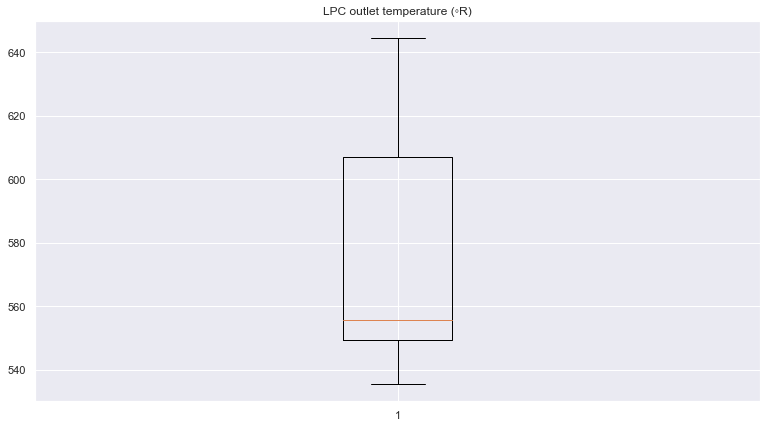

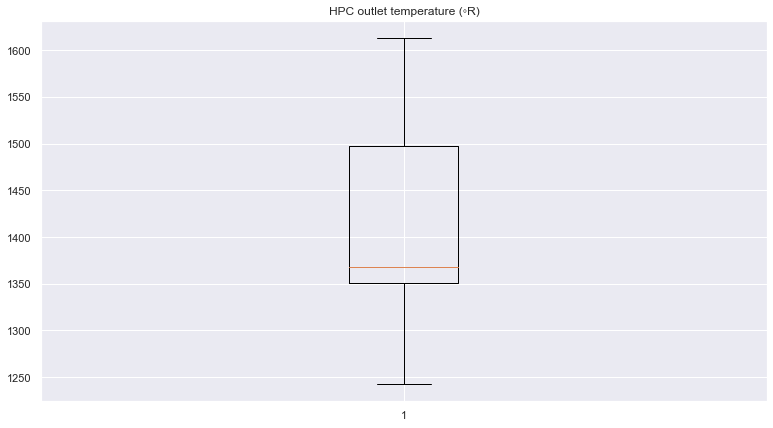

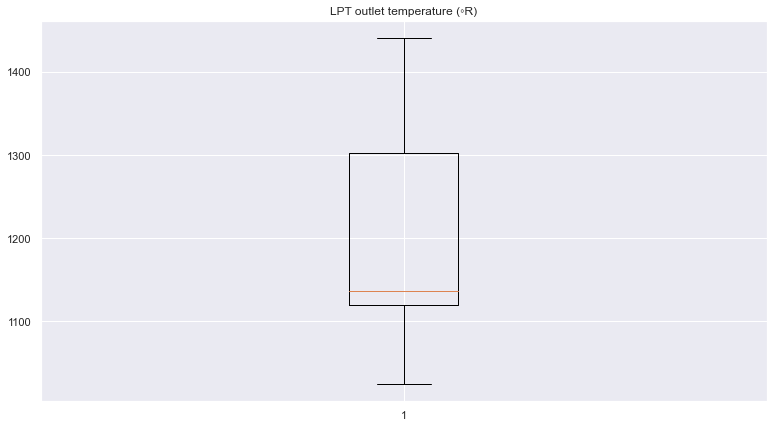

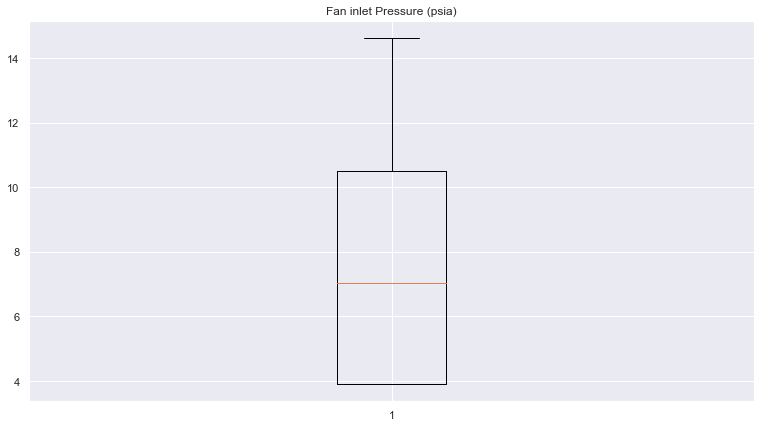

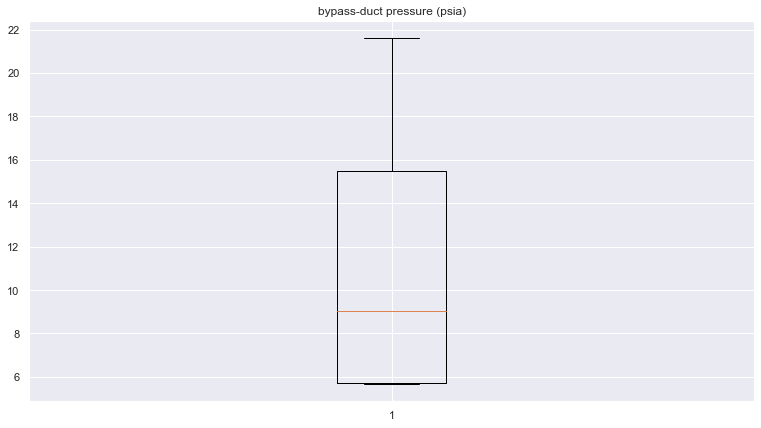

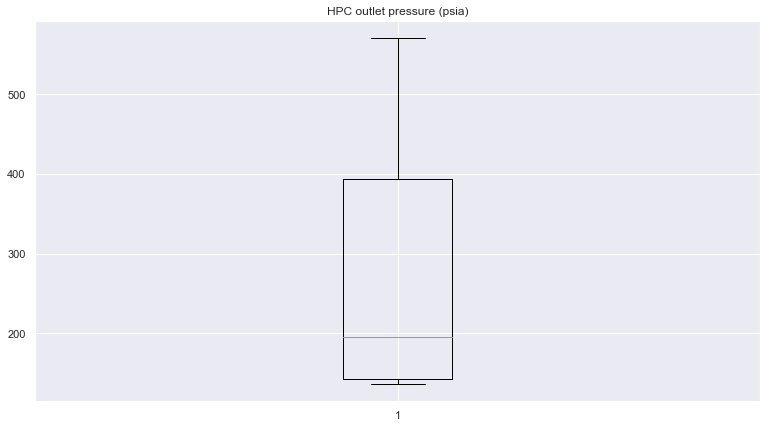

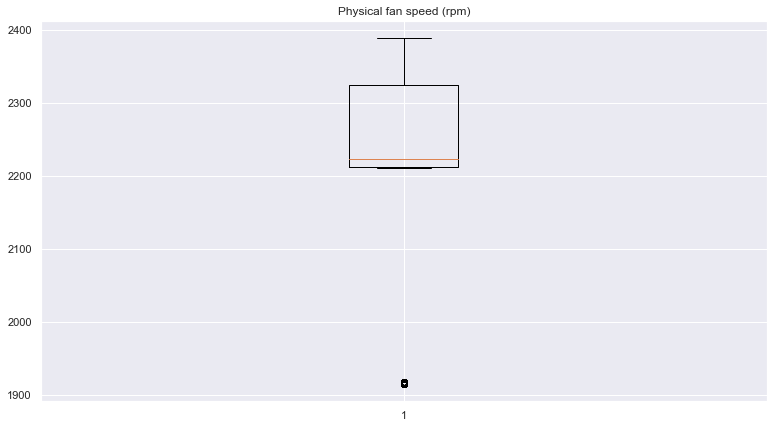

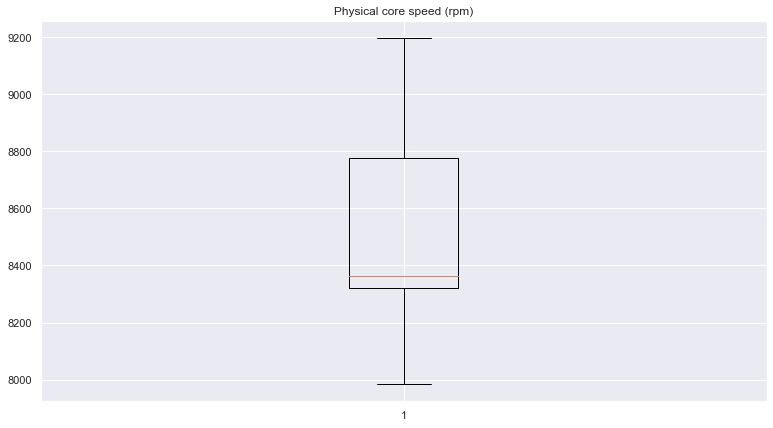

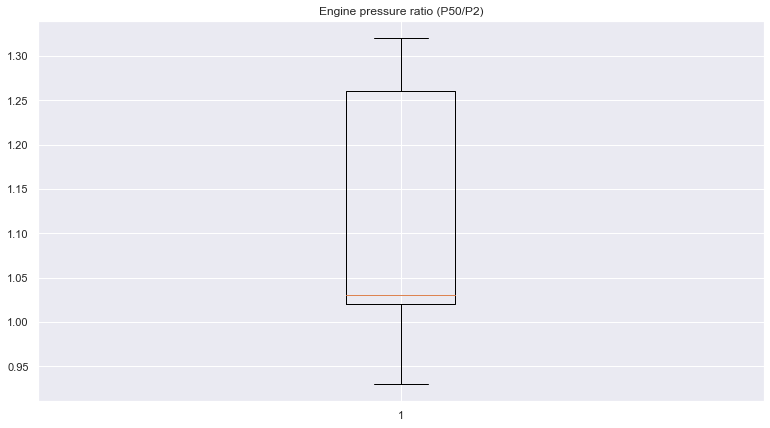

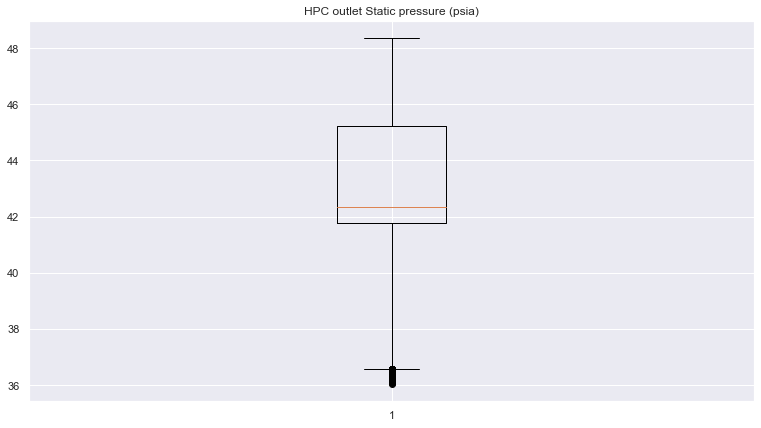

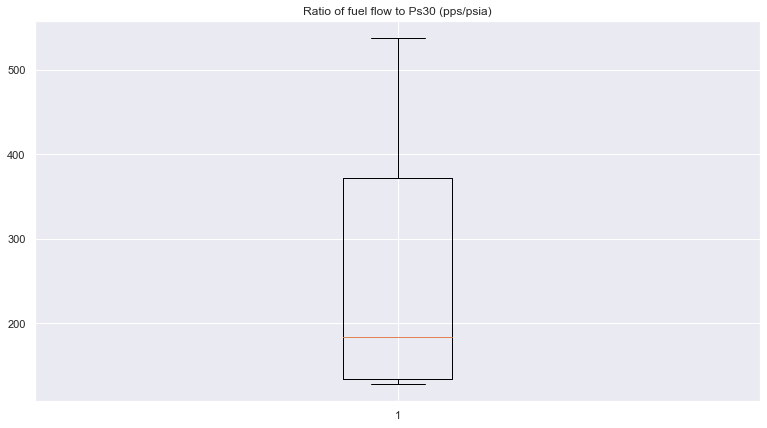

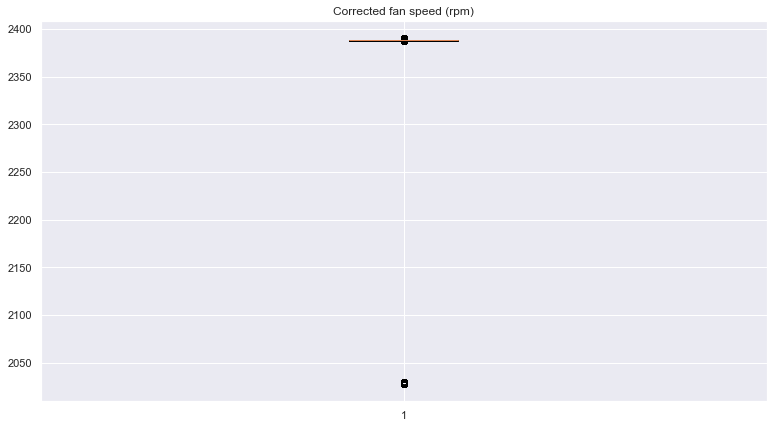

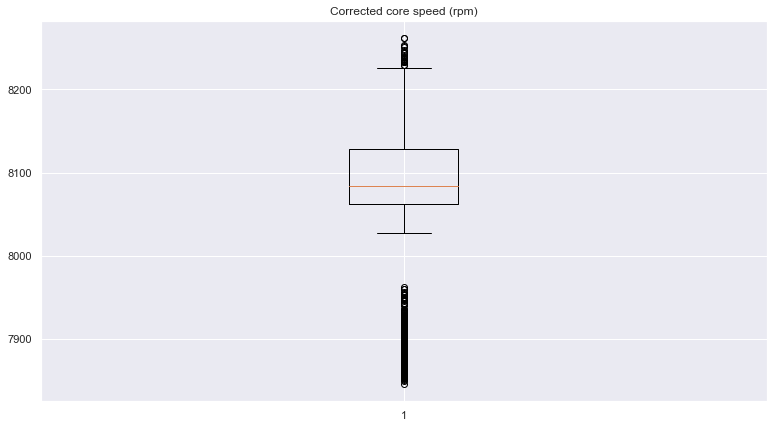

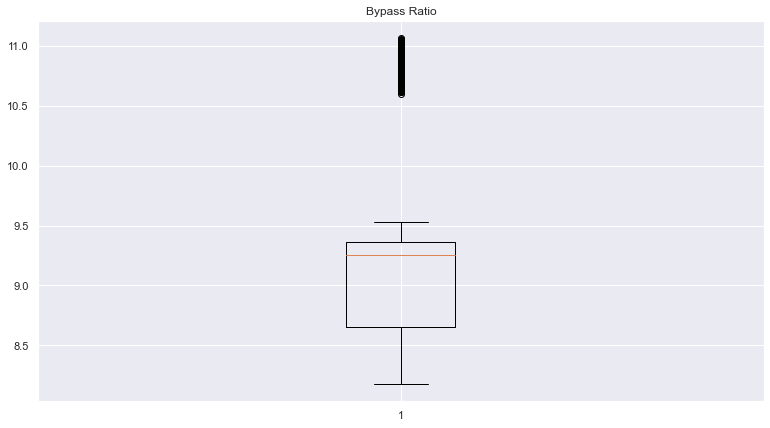

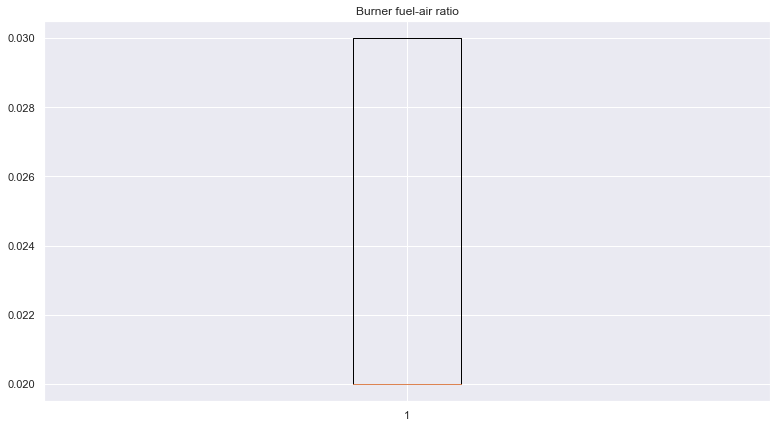

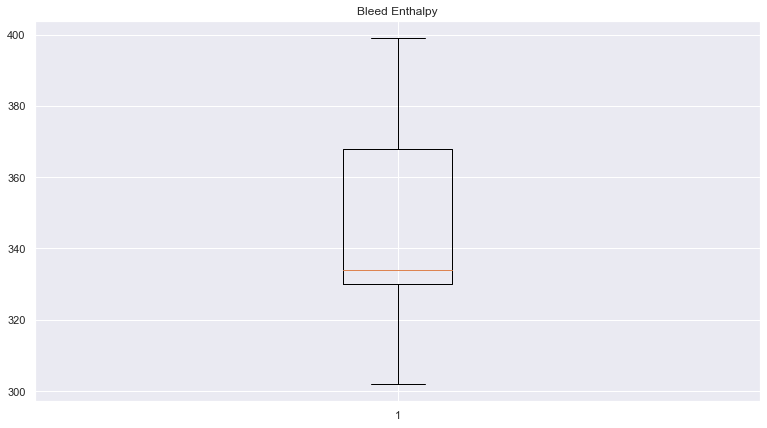

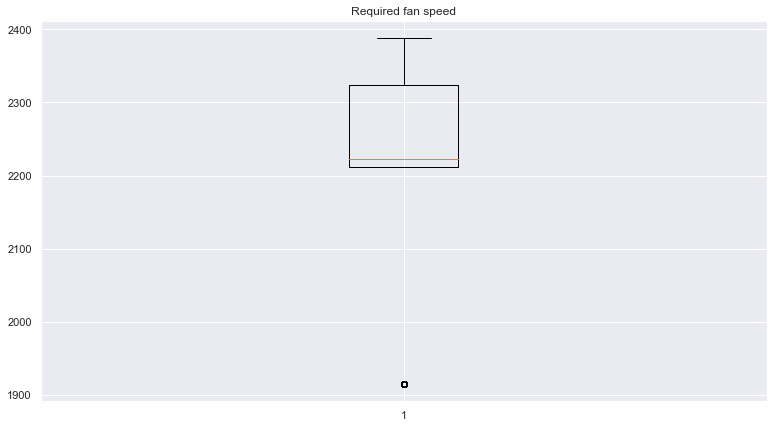

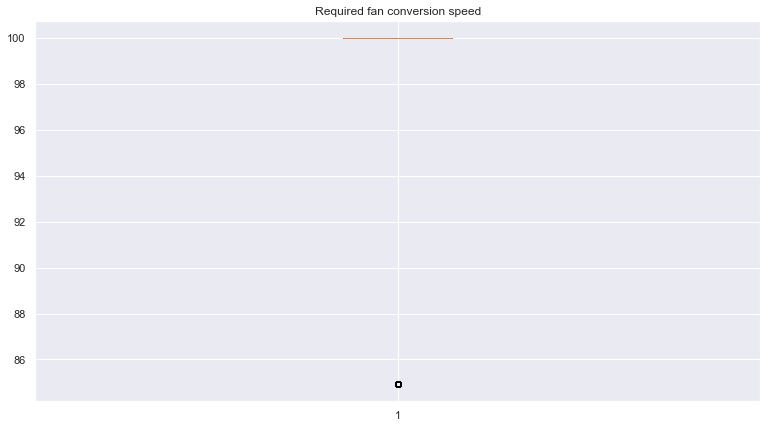

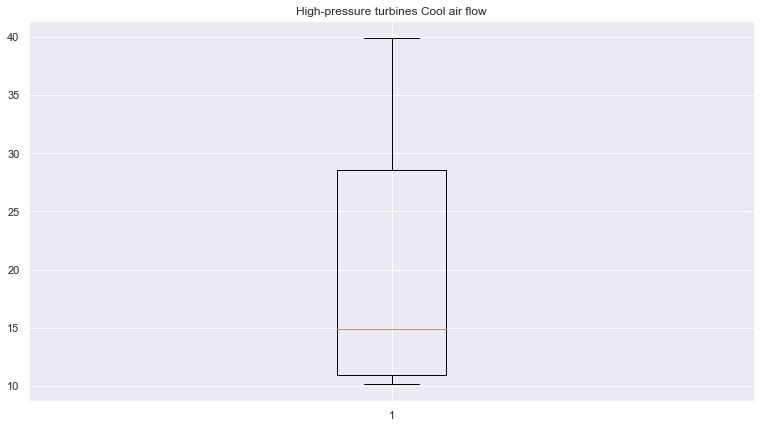

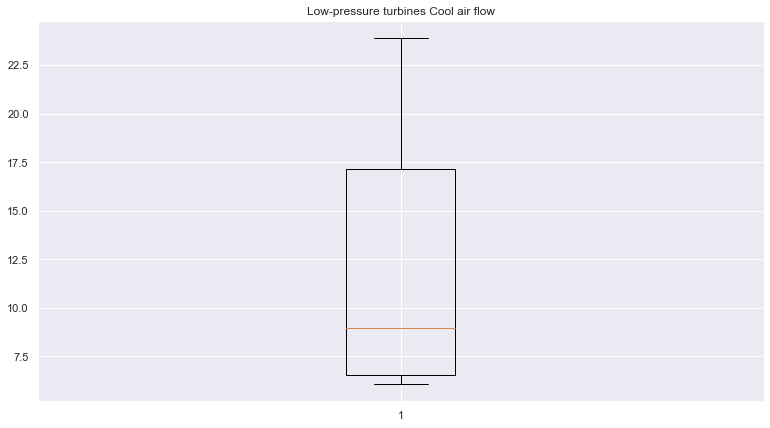

In [19]:
for x in sensor_names:
    plt.figure(figsize=(13,7))
    plt.boxplot(train[x])
    plt.title(x)
    plt.show()

## Max time cycle found for each Unit

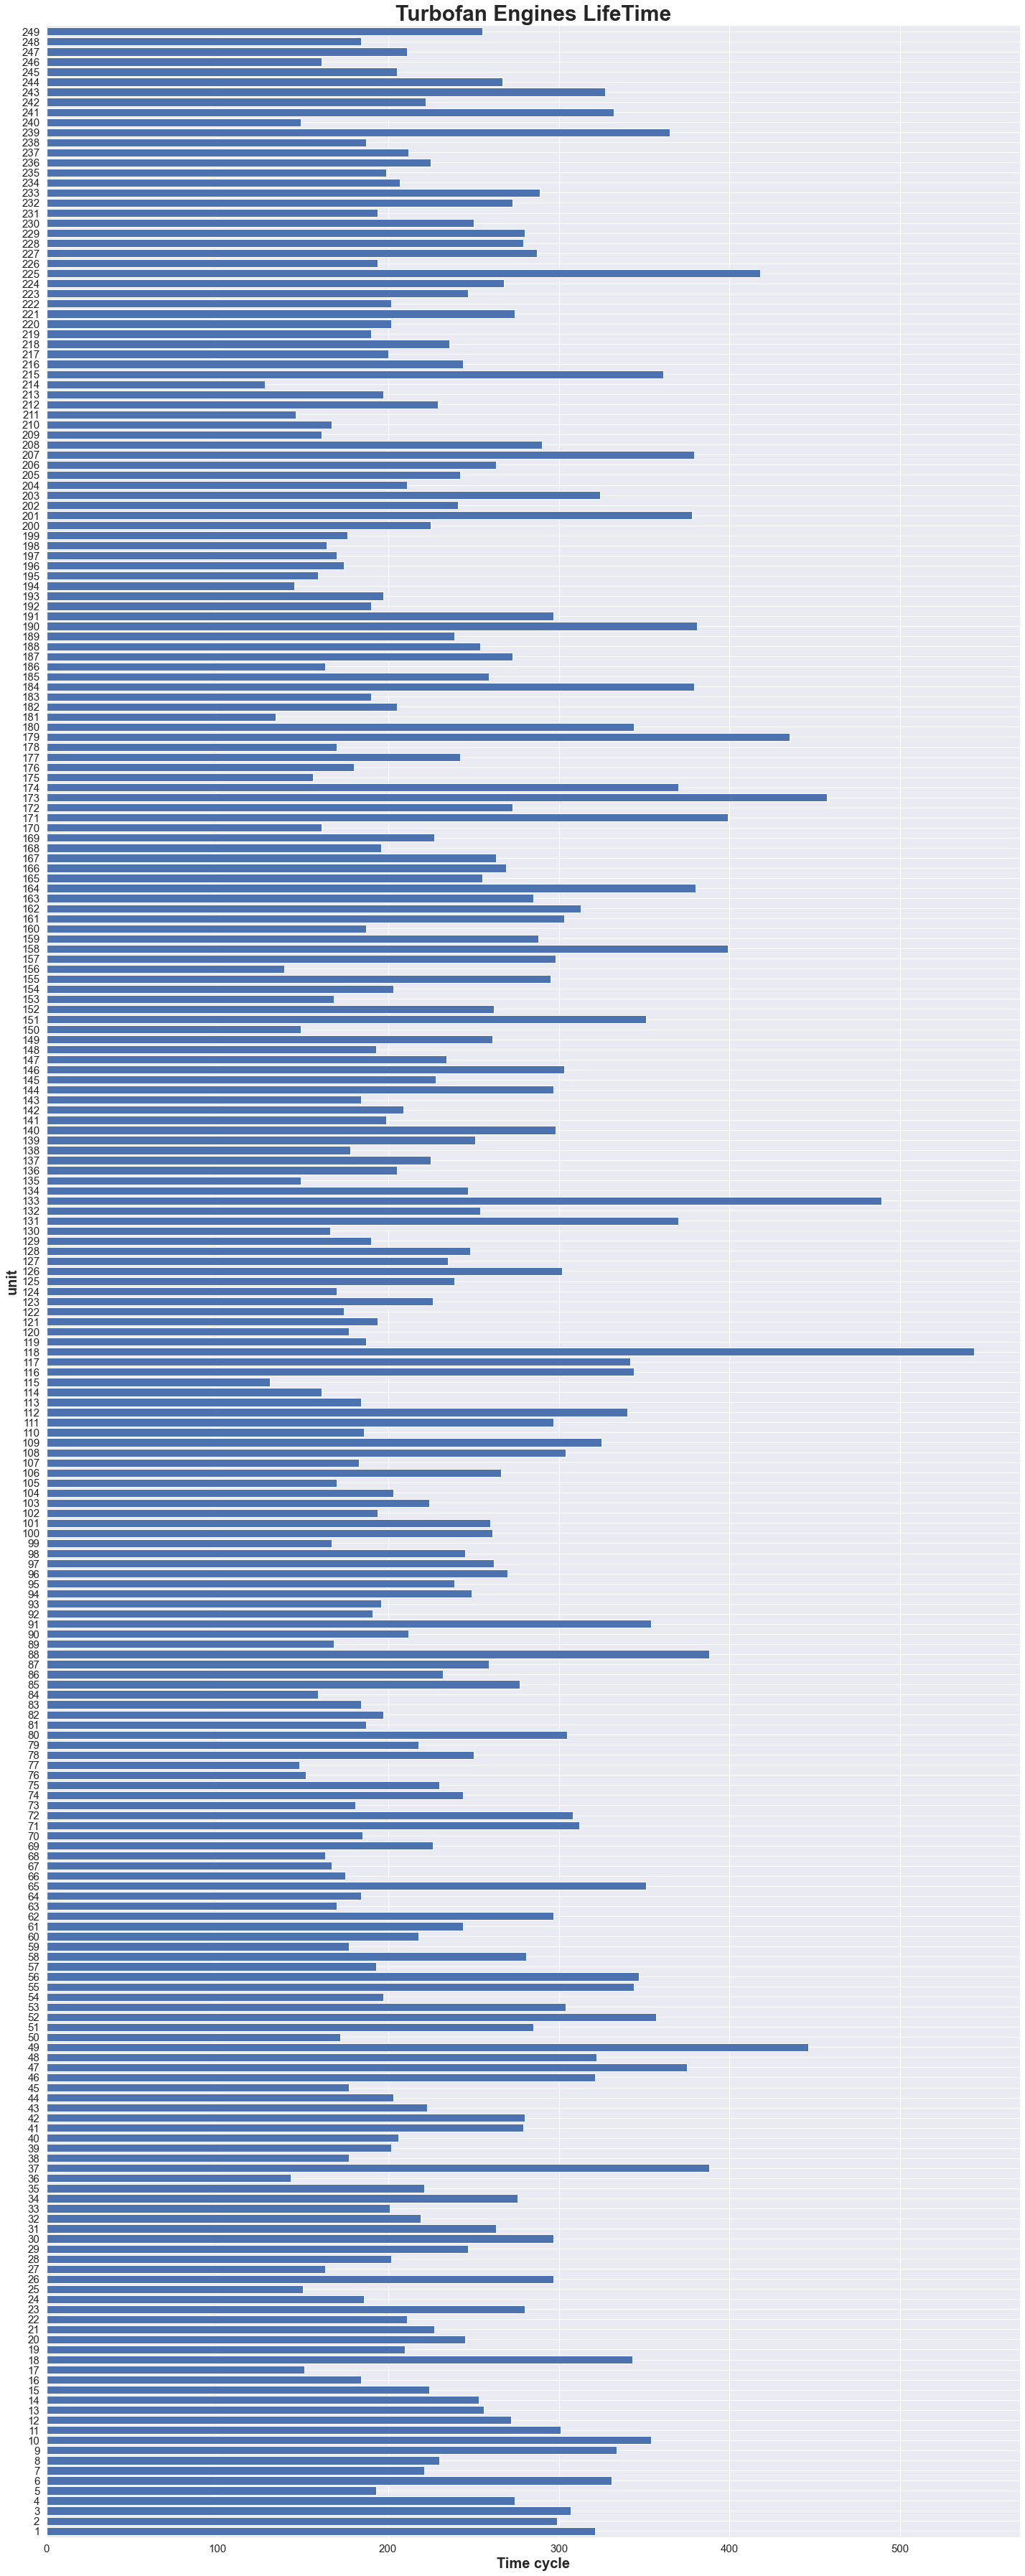

In [20]:
max_time_cycles=train[index_names].groupby('unit_nr').max()
plt.figure(figsize=(20,50))
ax=max_time_cycles['time_cycles'].plot(kind='barh',width=0.8, stacked=True,align='center')
plt.title('Turbofan Engines LifeTime',fontweight='bold',size=30)
plt.xlabel('Time cycle',fontweight='bold',size=20)
plt.xticks(size=15)
plt.ylabel('unit',fontweight='bold',size=20)
plt.yticks(size=15)
plt.grid(True)
plt.tight_layout()
plt.show()

Text(0.5, 8.959999999999994, 'max time cycle')

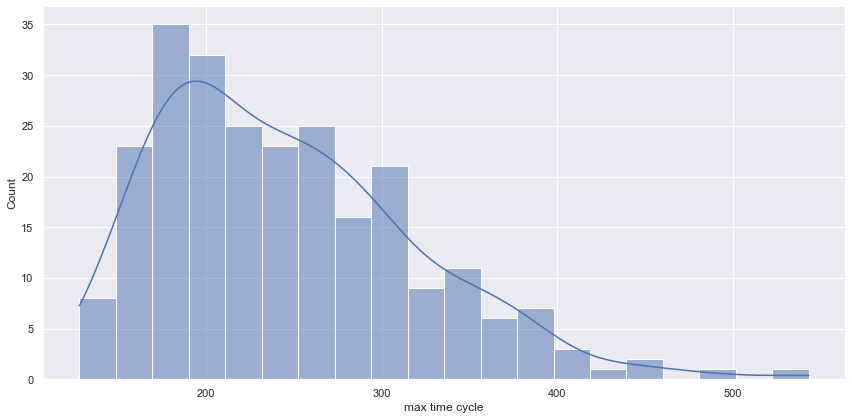

In [21]:
#Distribution of maximum time cycles
sns.displot(max_time_cycles['time_cycles'],kde=True,bins=20,height=6,aspect=2)
plt.xlabel('max time cycle')

## Extraction of only Important Features which have strong relation affecting RUL of engine

In [22]:
# This is done to select only important features for model building in order to avoid problem of " Overfitting".

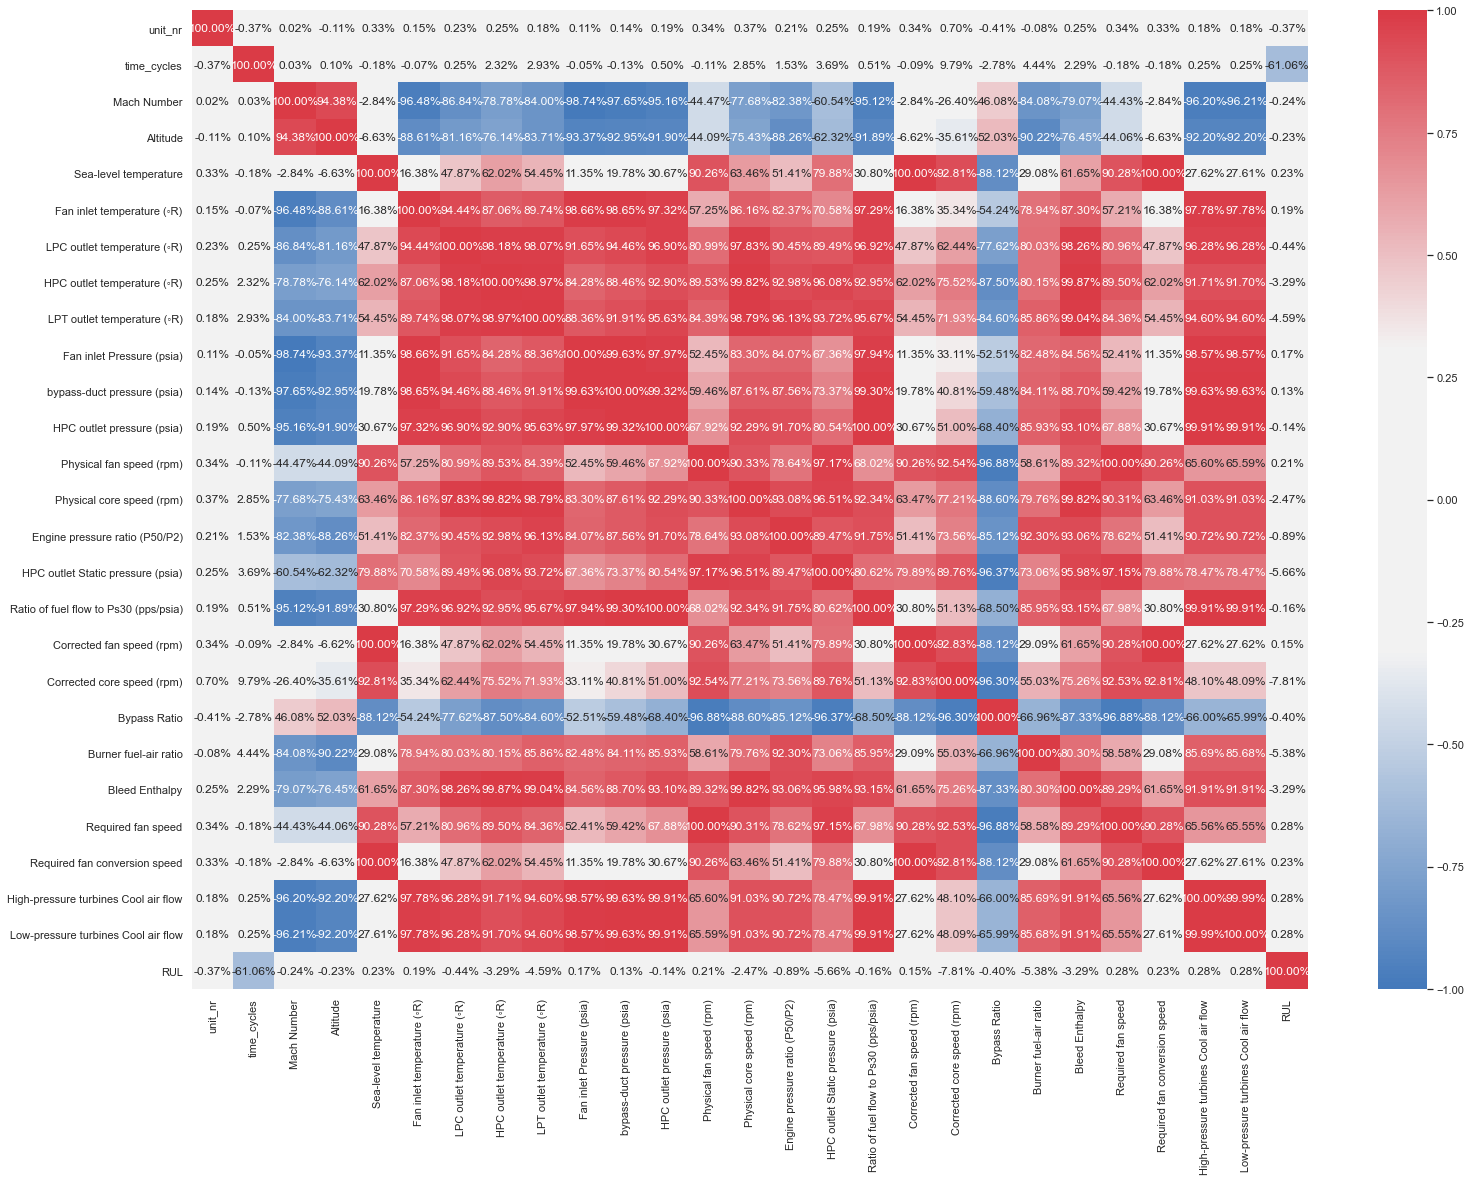

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(25, 18))
correlation_matrix = train.corr()

# Define a custom color map with varying shades
cmap = sns.diverging_palette(250, 10, sep=80, as_cmap=True)

sns.heatmap(correlation_matrix, annot=True, cmap=cmap, fmt='.2%', vmin=-1, vmax=1)
plt.show()


From the above heatmap we can see all the features are correlated with each other

In [24]:
train.head(5)

unit_nr  time_cycles  Mach Number  Altitude  Sea-level temperature  \
0        1            1      42.0049    0.8400                  100.0   
1        1            2      20.0020    0.7002                  100.0   
2        1            3      42.0038    0.8409                  100.0   
3        1            4      42.0000    0.8400                  100.0   
4        1            5      25.0063    0.6207                   60.0   

   Fan inlet temperature (◦R)  LPC outlet temperature (◦R)  \
0                      445.00                       549.68   
1                      491.19                       606.07   
2                      445.00                       548.95   
3                      445.00                       548.70   
4                      462.54                       536.10   

   HPC outlet temperature (◦R)  LPT outlet temperature (◦R)  \
0                      1343.43                      1112.93   
1                      1477.61                      1237.50   
2                      1343.12                      1117.05   
3                      1341.24                      1118.03   
4                      1255.23                      1033.59   

   Fan inlet Pressure (psia)  ...  Corrected fan speed (rpm)  \
0                       3.91  ...                    2387.99   
1                       9.35  ...                    2387.73   
2                       3.91  ...                    2387.97   
3                       3.91  ...                    2388.02   
4                       7.05  ...                    2028.08   

   Corrected core speed (rpm)  Bypass Ratio  Burner fuel-air ratio  \
0                     8074.83        9.3335                   0.02   
1                     8046.13        9.1913                   0.02   
2                     8066.62        9.4007                   0.02   
3                     8076.05        9.3369                   0.02   
4                     7865.80       10.8366                   0.02   

   Bleed Enthalpy  Required fan speed  Required fan conversion speed  \
0             330                2212                         100.00   
1             361                2324                         100.00   
2             329                2212                         100.00   
3             328                2212                         100.00   
4             305                1915                          84.93   

   High-pressure turbines Cool air flow  Low-pressure turbines Cool air flow  \
0                                 10.62                               6.3670   
1                                 24.37                              14.6552   
2                                 10.48                               6.4213   
3                                 10.54                               6.4176   
4                                 14.03                               8.6754   

   RUL  
0  320  
1  319  
2  318  
3  317  
4  316  

[5 rows x 27 columns]

## Seperating Train & Test Data

In [25]:
# train & y_train
# Calculated RUL variable is our Target variable.
y_train=train['RUL']
X_train=train.drop(['unit_nr','time_cycles','RUL'],axis=1)
X_train.head(5)

Mach Number  Altitude  Sea-level temperature  Fan inlet temperature (◦R)  \
0      42.0049    0.8400                  100.0                      445.00   
1      20.0020    0.7002                  100.0                      491.19   
2      42.0038    0.8409                  100.0                      445.00   
3      42.0000    0.8400                  100.0                      445.00   
4      25.0063    0.6207                   60.0                      462.54   

   LPC outlet temperature (◦R)  HPC outlet temperature (◦R)  \
0                       549.68                      1343.43   
1                       606.07                      1477.61   
2                       548.95                      1343.12   
3                       548.70                      1341.24   
4                       536.10                      1255.23   

   LPT outlet temperature (◦R)  Fan inlet Pressure (psia)  \
0                      1112.93                       3.91   
1                      1237.50                       9.35   
2                      1117.05                       3.91   
3                      1118.03                       3.91   
4                      1033.59                       7.05   

   bypass-duct pressure (psia)  HPC outlet pressure (psia)  ...  \
0                         5.70                      137.36  ...   
1                        13.61                      332.10  ...   
2                         5.69                      138.18  ...   
3                         5.70                      137.98  ...   
4                         9.00                      174.82  ...   

   Ratio of fuel flow to Ps30 (pps/psia)  Corrected fan speed (rpm)  \
0                                 129.78                    2387.99   
1                                 312.59                    2387.73   
2                                 129.62                    2387.97   
3                                 129.80                    2388.02   
4                                 164.11                    2028.08   

   Corrected core speed (rpm)  Bypass Ratio  Burner fuel-air ratio  \
0                     8074.83        9.3335                   0.02   
1                     8046.13        9.1913                   0.02   
2                     8066.62        9.4007                   0.02   
3                     8076.05        9.3369                   0.02   
4                     7865.80       10.8366                   0.02   

   Bleed Enthalpy  Required fan speed  Required fan conversion speed  \
0             330                2212                         100.00   
1             361                2324                         100.00   
2             329                2212                         100.00   
3             328                2212                         100.00   
4             305                1915                          84.93   

   High-pressure turbines Cool air flow  Low-pressure turbines Cool air flow  
0                                 10.62                               6.3670  
1                                 24.37                              14.6552  
2                                 10.48                               6.4213  
3                                 10.54                               6.4176  
4                                 14.03                               8.6754  

[5 rows x 24 columns]

In [26]:
test.head(5)

Mach Number  Altitude  Sea-level temperature  Fan inlet temperature (◦R)  \
0      25.0070    0.6214                   60.0                      462.54   
1      41.9989    0.8400                  100.0                      445.00   
2      42.0005    0.8401                  100.0                      445.00   
3      25.0018    0.6207                   60.0                      462.54   
4      25.0039    0.6200                   60.0                      462.54   

   LPC outlet temperature (◦R)  HPC outlet temperature (◦R)  \
0                       537.66                      1264.31   
1                       549.96                      1354.05   
2                       549.47                      1341.06   
3                       536.06                      1253.49   
4                       537.36                      1263.60   

   LPT outlet temperature (◦R)  Fan inlet Pressure (psia)  \
0                      1046.41                       7.05   
1                      1133.55                       3.91   
2                      1118.90                       3.91   
3                      1038.53                       7.05   
4                      1052.52                       7.05   

   bypass-duct pressure (psia)  HPC outlet pressure (psia)  ...  \
0                         8.99                      176.56  ...   
1                         5.72                      139.03  ...   
2                         5.69                      139.26  ...   
3                         9.00                      175.63  ...   
4                         9.03                      175.53  ...   

   Ratio of fuel flow to Ps30 (pps/psia)  Corrected fan speed (rpm)  \
0                                 166.19                    2028.53   
1                                 130.17                    2387.72   
2                                 130.73                    2388.18   
3                                 164.91                    2028.30   
4                                 164.95                    2028.24   

   Corrected core speed (rpm)  Bypass Ratio  Burner fuel-air ratio  \
0                     7890.31       10.7615                   0.02   
1                     8073.44        9.3925                   0.02   
2                     8095.58        9.2974                   0.02   
3                     7878.63       10.8396                   0.02   
4                     7873.75       10.9094                   0.02   

   Bleed Enthalpy  Required fan speed  Required fan conversion speed  \
0             308                1915                          84.93   
1             331                2212                         100.00   
2             330                2212                         100.00   
3             306                1915                          84.93   
4             307                1915                          84.93   

   High-pressure turbines Cool air flow  Low-pressure turbines Cool air flow  
0                                 14.41                               8.6329  
1                                 10.58                               6.4325  
2                                 10.61                               6.3488  
3                                 14.41                               8.5696  
4                                 14.19                               8.6248  

[5 rows x 24 columns]

In [27]:
# Check the columns in X_train
print(X_train.columns)

# Test data set, keeping only train columns/features.
X_test = test[X_train.columns]
X_test.head(5)


Index(['Mach Number', 'Altitude', 'Sea-level temperature',
       'Fan inlet temperature (◦R)', 'LPC outlet temperature (◦R)',
       'HPC outlet temperature (◦R)', 'LPT outlet temperature (◦R)',
       'Fan inlet Pressure (psia)', 'bypass-duct pressure (psia)',
       'HPC outlet pressure (psia)', 'Physical fan speed (rpm)',
       'Physical core speed (rpm)', 'Engine pressure ratio (P50/P2)',
       'HPC outlet Static pressure (psia)',
       'Ratio of fuel flow to Ps30 (pps/psia)', 'Corrected fan speed (rpm)',
       'Corrected core speed (rpm)', 'Bypass Ratio', 'Burner fuel-air ratio',
       'Bleed Enthalpy', 'Required fan speed', 'Required fan conversion speed',
       'High-pressure turbines Cool air flow',
       'Low-pressure turbines Cool air flow'],
      dtype='object')


Mach Number  Altitude  Sea-level temperature  Fan inlet temperature (◦R)  \
0      25.0070    0.6214                   60.0                      462.54   
1      41.9989    0.8400                  100.0                      445.00   
2      42.0005    0.8401                  100.0                      445.00   
3      25.0018    0.6207                   60.0                      462.54   
4      25.0039    0.6200                   60.0                      462.54   

   LPC outlet temperature (◦R)  HPC outlet temperature (◦R)  \
0                       537.66                      1264.31   
1                       549.96                      1354.05   
2                       549.47                      1341.06   
3                       536.06                      1253.49   
4                       537.36                      1263.60   

   LPT outlet temperature (◦R)  Fan inlet Pressure (psia)  \
0                      1046.41                       7.05   
1                      1133.55                       3.91   
2                      1118.90                       3.91   
3                      1038.53                       7.05   
4                      1052.52                       7.05   

   bypass-duct pressure (psia)  HPC outlet pressure (psia)  ...  \
0                         8.99                      176.56  ...   
1                         5.72                      139.03  ...   
2                         5.69                      139.26  ...   
3                         9.00                      175.63  ...   
4                         9.03                      175.53  ...   

   Ratio of fuel flow to Ps30 (pps/psia)  Corrected fan speed (rpm)  \
0                                 166.19                    2028.53   
1                                 130.17                    2387.72   
2                                 130.73                    2388.18   
3                                 164.91                    2028.30   
4                                 164.95                    2028.24   

   Corrected core speed (rpm)  Bypass Ratio  Burner fuel-air ratio  \
0                     7890.31       10.7615                   0.02   
1                     8073.44        9.3925                   0.02   
2                     8095.58        9.2974                   0.02   
3                     7878.63       10.8396                   0.02   
4                     7873.75       10.9094                   0.02   

   Bleed Enthalpy  Required fan speed  Required fan conversion speed  \
0             308                1915                          84.93   
1             331                2212                         100.00   
2             330                2212                         100.00   
3             306                1915                          84.93   
4             307                1915                          84.93   

   High-pressure turbines Cool air flow  Low-pressure turbines Cool air flow  
0                                 14.41                               8.6329  
1                                 10.58                               6.4325  
2                                 10.61                               6.3488  
3                                 14.41                               8.5696  
4                                 14.19                               8.6248  

[5 rows x 24 columns]

In [28]:
y_test.head(5)

RUL
0   22
1   39
2  107
3   75
4  149

In [29]:
y_train.describe()

count    61249.000000
mean       133.311417
std         89.783389
min          0.000000
25%         61.000000
50%        122.000000
75%        190.000000
max        542.000000
Name: RUL, dtype: float64

In [30]:

y_train= y_train.clip(upper=103)
y_train.head(5)

0    103
1    103
2    103
3    103
4    103
Name: RUL, dtype: int64

In [31]:
y_test.describe()

RUL
count  248.000000
mean    86.552419
std     54.634054
min      6.000000
25%     36.000000
50%     88.000000
75%    126.750000
max    195.000000

In [32]:
y_test= y_test.clip(upper=103)
y_test.head(5)

RUL
0   22
1   39
2  103
3   75
4  103

## Building Model

In [33]:
# first create an evaluate function
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))
    return rmse,variance;

## Bi-LSTM model

In [34]:
# Model: Bidirectional LSTM
def build_bilstm_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=input_shape))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [35]:
# Preprocess data for LSTM
scaler_lstm = StandardScaler()
X_train_lstm = scaler_lstm.fit_transform(X_train)
X_test_lstm = scaler_lstm.transform(X_test)

In [36]:
# Reshape input for LSTM 
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], 1, X_train_lstm.shape[1]))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], 1, X_test_lstm.shape[1]))


In [37]:
# Build and train the Bidirectional LSTM model
input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
bilstm_model = build_bilstm_model(input_shape)


In [38]:
# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



In [39]:
# Train the model
bilstm_model.fit(X_train_lstm, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/100
1532/1532 [==============================] - 10s 4ms/step - loss: 1722.1659 - mae: 33.3195 - val_loss: 788.5070 - val_mae: 23.8441
Epoch 2/100
1532/1532 [==============================] - 5s 3ms/step - loss: 574.6531 - mae: 19.4136 - val_loss: 488.6975 - val_mae: 17.7518
Epoch 3/100
1532/1532 [==============================] - 5s 3ms/step - loss: 432.1986 - mae: 16.0226 - val_loss: 414.3503 - val_mae: 16.2441
Epoch 4/100
1532/1532 [==============================] - 5s 3ms/step - loss: 388.8094 - mae: 15.3254 - val_loss: 387.7004 - val_mae: 15.3348
Epoch 5/100
1532/1532 [==============================] - 5s 3ms/step - loss: 363.0495 - mae: 14.9303 - val_loss: 367.1871 - val_mae: 14.9744
Epoch 6/100
1532/1532 [==============================] - 6s 4ms/step - loss: 348.0067 - mae: 14.7174 - val_loss: 342.4587 - val_mae: 14.9770
Epoch 7/100
1532/1532 [==============================] - 5s 3ms/step - loss: 337.5002 - mae: 14.5426 - val_loss: 328.6572 - val_mae: 14.3973
Epoch 8/100

In [40]:
# Evaluate on train data
y_hat_train_lstm = bilstm_model.predict(X_train_lstm)
RMSE_Train_LSTM, R2_Train_LSTM = evaluate(y_train, y_hat_train_lstm, 'train')

1915/1915 [==============================] - 4s 2ms/step
train set RMSE:14.932073861710608, R2:0.7831699721801734


In [41]:
# Evaluate on test data
y_hat_test_lstm = bilstm_model.predict(X_test_lstm)
RMSE_Test_LSTM, R2_Test_LSTM = evaluate(y_test, y_hat_test_lstm, 'test')


8/8 [==============================] - 0s 2ms/step
test set RMSE:16.819751084332935, R2:0.7794480339001041


In [42]:
# Make Dataframe which will contain results of all applied Model
Results=pd.DataFrame({'Model': ['BiLSTM'],
    'RMSE-Train': [RMSE_Train_LSTM],
    'R2-Train': [R2_Train_LSTM],
    'RMSE-Test': [RMSE_Test_LSTM],
    'R2-Test': [R2_Test_LSTM]})
Results

Model  RMSE-Train  R2-Train  RMSE-Test   R2-Test
0  BiLSTM   14.932074   0.78317  16.819751  0.779448

## Bi-TRNN model

In [43]:
# Model: Bidirectional TRNN 
def Bi_trnn(input_shape):
    model = Sequential()
    model.add(Bidirectional(SimpleRNN(50, activation='relu'), input_shape=input_shape))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [44]:
# Preprocess data for Bi-TRNN
scaler_bi_trnn = StandardScaler()
X_train_bi_trnn = scaler_bi_trnn.fit_transform(X_train)
X_test_bi_trnn = scaler_bi_trnn.transform(X_test)


In [45]:
# Reshape input for Bi-TRNN 
X_train_bi_trnn = X_train_bi_trnn.reshape((X_train_bi_trnn.shape[0], X_train_bi_trnn.shape[1], 1))
X_test_bi_trnn = X_test_bi_trnn.reshape((X_test_bi_trnn.shape[0], X_test_bi_trnn.shape[1], 1))


In [46]:
# Build and train the Bidirectional TRNN model
input_shape_bi_trnn = (X_train_bi_trnn.shape[1], X_train_bi_trnn.shape[2])
bi_trnn_model = Bi_trnn(input_shape_bi_trnn)

# Define early stopping to prevent overfitting
early_stopping_bi_trnn = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [47]:
# Train the model
bi_trnn_model.fit(X_train_bi_trnn, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping_bi_trnn])


Epoch 1/50
1532/1532 [==============================] - 14s 7ms/step - loss: 1100.7695 - mae: 26.6421 - val_loss: 547.0522 - val_mae: 18.0052
Epoch 2/50
1532/1532 [==============================] - 11s 7ms/step - loss: 485.7693 - mae: 16.5103 - val_loss: 476.1830 - val_mae: 15.4314
Epoch 3/50
1532/1532 [==============================] - 11s 7ms/step - loss: 387.6656 - mae: 14.4262 - val_loss: 344.2153 - val_mae: 13.0194
Epoch 4/50
1532/1532 [==============================] - 11s 7ms/step - loss: 355.9377 - mae: 13.7829 - val_loss: 300.6270 - val_mae: 11.8330
Epoch 5/50
1532/1532 [==============================] - 11s 7ms/step - loss: 330.2605 - mae: 13.1894 - val_loss: 365.2709 - val_mae: 15.1595
Epoch 6/50
1532/1532 [==============================] - 11s 7ms/step - loss: 324.8102 - mae: 13.0849 - val_loss: 361.4127 - val_mae: 15.2862
Epoch 7/50
1532/1532 [==============================] - 11s 7ms/step - loss: 314.9224 - mae: 12.8154 - val_loss: 415.3329 - val_mae: 17.6441
Epoch 8/50
1

In [48]:
# Evaluate on train data
y_hat_train_bi_trnn = bi_trnn_model.predict(X_train_bi_trnn)
RMSE_Train_BiTRNN, R2_Train_BiTRNN = evaluate(y_train, y_hat_train_bi_trnn, 'train')


1915/1915 [==============================] - 4s 2ms/step
train set RMSE:14.498231794263091, R2:0.7955866553662287


In [49]:
# Evaluate on test data
y_hat_test_bi_trnn = bi_trnn_model.predict(X_test_bi_trnn)
RMSE_Test_BiTRNN, R2_Test_BiTRNN = evaluate(y_test, y_hat_test_bi_trnn, 'test')


8/8 [==============================] - 0s 2ms/step
test set RMSE:16.630237673419856, R2:0.784390090662745


In [50]:
# Add results to the DataFrame
Results = Results.append(pd.DataFrame({
    'Model': ['BiTRNN'],
    'RMSE-Train': [RMSE_Train_BiTRNN],
    'R2-Train': [R2_Train_BiTRNN],
    'RMSE-Test': [RMSE_Test_BiTRNN],
    'R2-Test': [R2_Test_BiTRNN]
}), ignore_index=True)

# Display the results DataFrame
Results


Model  RMSE-Train  R2-Train  RMSE-Test   R2-Test
0  BiLSTM   14.932074  0.783170  16.819751  0.779448
1  BiTRNN   14.498232  0.795587  16.630238  0.784390

## Bi-GRU model

In [51]:
# Model: Bidirectional GRU (Bi-GRU)
def build_bi_gru_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(GRU(50, activation='relu'), input_shape=input_shape))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [52]:
# Preprocess data for GRU
scaler_bi_gru = StandardScaler()
X_train_bi_gru = scaler_bi_gru.fit_transform(X_train)
X_test_bi_gru = scaler_bi_gru.transform(X_test)


In [53]:
# Reshape input for GRU 
X_train_bi_gru = X_train_bi_gru.reshape((X_train_bi_gru.shape[0], 1, X_train_bi_gru.shape[1]))
X_test_bi_gru = X_test_bi_gru.reshape((X_test_bi_gru.shape[0], 1, X_test_bi_gru.shape[1]))


In [54]:
# Build and train the Bidirectional GRU model
input_shape_bi_gru = (X_train_bi_gru.shape[1], X_train_bi_gru.shape[2])
bi_gru_model = build_bi_gru_model(input_shape_bi_gru)


In [55]:
# Define early stopping to prevent overfitting
early_stopping_bi_gru = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [56]:
# Train the model
bi_gru_model.fit(X_train_bi_gru, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping_bi_gru])


Epoch 1/50
1532/1532 [==============================] - 6s 3ms/step - loss: 1700.5913 - mae: 33.2000 - val_loss: 787.8069 - val_mae: 23.5001
Epoch 2/50
1532/1532 [==============================] - 4s 2ms/step - loss: 591.2866 - mae: 19.7838 - val_loss: 490.7741 - val_mae: 17.7425
Epoch 3/50
1532/1532 [==============================] - 4s 2ms/step - loss: 431.8819 - mae: 15.9774 - val_loss: 418.1653 - val_mae: 16.4568
Epoch 4/50
1532/1532 [==============================] - 4s 2ms/step - loss: 387.1344 - mae: 15.1569 - val_loss: 386.3023 - val_mae: 15.2639
Epoch 5/50
1532/1532 [==============================] - 4s 2ms/step - loss: 361.1290 - mae: 14.7466 - val_loss: 353.9002 - val_mae: 14.8063
Epoch 6/50
1532/1532 [==============================] - 4s 2ms/step - loss: 341.8691 - mae: 14.3861 - val_loss: 336.7747 - val_mae: 14.1810
Epoch 7/50
1532/1532 [==============================] - 4s 2ms/step - loss: 330.0285 - mae: 14.1582 - val_loss: 318.2090 - val_mae: 14.2214
Epoch 8/50
1532/153

In [57]:
# Evaluate on train data
y_hat_train_bi_gru = bi_gru_model.predict(X_train_bi_gru)
RMSE_Train_BiGRU, R2_Train_BiGRU = evaluate(y_train, y_hat_train_bi_gru, 'train')


1915/1915 [==============================] - 3s 2ms/step
train set RMSE:14.907611135565334, R2:0.7838798412509396


In [58]:
# Evaluate on test data
y_hat_test_bi_gru = bi_gru_model.predict(X_test_bi_gru)
RMSE_Test_BiGRU, R2_Test_BiGRU = evaluate(y_test, y_hat_test_bi_gru, 'test')


8/8 [==============================] - 0s 1ms/step
test set RMSE:17.594899012890057, R2:0.758651078809669


In [59]:
# Add results to the DataFrame
Results = Results.append(pd.DataFrame({
    'Model': ['BiGRU'],
    'RMSE-Train': [RMSE_Train_BiGRU],
    'R2-Train': [R2_Train_BiGRU],
    'RMSE-Test': [RMSE_Test_BiGRU],
    'R2-Test': [R2_Test_BiGRU]
}), ignore_index=True)


In [60]:
# Display the results DataFrame
Results


Model  RMSE-Train  R2-Train  RMSE-Test   R2-Test
0  BiLSTM   14.932074  0.783170  16.819751  0.779448
1  BiTRNN   14.498232  0.795587  16.630238  0.784390
2   BiGRU   14.907611  0.783880  17.594899  0.758651

## Prognet model

In [61]:
# Model: ProgNet (Progressive Neural Network)
def build_prognet_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [62]:
# Preprocess data for ProgNet
scaler_prognet = StandardScaler()
X_train_prognet = scaler_prognet.fit_transform(X_train)
X_test_prognet = scaler_prognet.transform(X_test)


In [63]:
# Reshape input for LSTM 
X_train_prognet = X_train_prognet.reshape((X_train_prognet.shape[0], X_train_prognet.shape[1], 1))

# Build and train the ProgNet model
input_shape_prognet = (X_train_prognet.shape[1], X_train_prognet.shape[2])
prognet_model = build_prognet_model(input_shape_prognet)


In [64]:
# Define early stopping to prevent overfitting
early_stopping_prognet = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [65]:
# Train the model
prognet_model.fit(X_train_prognet, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping_prognet])


Epoch 1/50
1532/1532 [==============================] - 29s 17ms/step - loss: 1215.7001 - mae: 28.7651 - val_loss: 1077.5690 - val_mae: 25.4338
Epoch 2/50
1532/1532 [==============================] - 25s 16ms/step - loss: 904.1353 - mae: 24.6222 - val_loss: 567.6174 - val_mae: 16.6919
Epoch 3/50
1532/1532 [==============================] - 26s 17ms/step - loss: 520.1065 - mae: 16.8365 - val_loss: 443.7248 - val_mae: 14.2422
Epoch 4/50
1532/1532 [==============================] - 25s 16ms/step - loss: 455.8221 - mae: 15.3864 - val_loss: 454.3066 - val_mae: 16.8613
Epoch 5/50
1532/1532 [==============================] - 26s 17ms/step - loss: 419.4930 - mae: 14.5872 - val_loss: 389.5102 - val_mae: 12.5872
Epoch 6/50
1532/1532 [==============================] - 25s 16ms/step - loss: 370.5130 - mae: 13.6346 - val_loss: 319.8085 - val_mae: 12.3923
Epoch 7/50
1532/1532 [==============================] - 28s 18ms/step - loss: 330.5576 - mae: 12.8553 - val_loss: 283.7757 - val_mae: 11.5650
Epoc

In [66]:
# Evaluate on train data
y_hat_train_prognet = prognet_model.predict(X_train_prognet)
RMSE_Train_ProgNet, R2_Train_ProgNet = evaluate(y_train, y_hat_train_prognet, 'train')


1915/1915 [==============================] - 12s 6ms/step
train set RMSE:14.95482306485048, R2:0.7825087823255454


In [67]:
# Reshape input for LSTM 
X_test_prognet = X_test_prognet.reshape((X_test_prognet.shape[0], X_test_prognet.shape[1], 1))

# Evaluate on test data
y_hat_test_prognet = prognet_model.predict(X_test_prognet)

# Now you can proceed with the evaluation
RMSE_Test_ProgNet, R2_Test_ProgNet = evaluate(y_test, y_hat_test_prognet, 'test')


8/8 [==============================] - 0s 6ms/step
test set RMSE:17.049716483600395, R2:0.7733758813868442


In [68]:
# Add results to the DataFrame
Results = Results.append(pd.DataFrame({
    'Model': ['ProgNet'],
    'RMSE-Train': [RMSE_Train_ProgNet],
    'R2-Train': [R2_Train_ProgNet],
    'RMSE-Test': [RMSE_Test_ProgNet],
    'R2-Test': [R2_Test_ProgNet]
}), ignore_index=True)

In [69]:
# Display the results DataFrame
Results


Model  RMSE-Train  R2-Train  RMSE-Test   R2-Test
0   BiLSTM   14.932074  0.783170  16.819751  0.779448
1   BiTRNN   14.498232  0.795587  16.630238  0.784390
2    BiGRU   14.907611  0.783880  17.594899  0.758651
3  ProgNet   14.954823  0.782509  17.049716  0.773376

## DCNN model

In [70]:
# Model: Deep Convolutional Neural Network (DCNN)
def build_dcnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [71]:
# Preprocess data for DCNN
scaler_dcnn = StandardScaler()
X_train_dcnn = scaler_dcnn.fit_transform(X_train)
X_test_dcnn = scaler_dcnn.transform(X_test)

In [72]:
# Reshape input for DCNN 
X_train_dcnn = X_train_dcnn.reshape((X_train_dcnn.shape[0], X_train_dcnn.shape[1], 1))
X_test_dcnn = X_test_dcnn.reshape((X_test_dcnn.shape[0], X_test_dcnn.shape[1], 1))


In [73]:
# Build and train the DCNN model
input_shape_dcnn = (X_train_dcnn.shape[1], X_train_dcnn.shape[2])
dcnn_model = build_dcnn_model(input_shape_dcnn)

In [74]:
# Define early stopping to prevent overfitting
early_stopping_dcnn = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [75]:
# Train the model
dcnn_model.fit(X_train_dcnn, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping_dcnn])


Epoch 1/50
1532/1532 [==============================] - 6s 3ms/step - loss: 1171.7236 - mae: 28.0462 - val_loss: 786.4918 - val_mae: 23.4980
Epoch 2/50
1532/1532 [==============================] - 5s 3ms/step - loss: 576.1014 - mae: 18.5796 - val_loss: 495.0038 - val_mae: 16.6144
Epoch 3/50
1532/1532 [==============================] - 5s 3ms/step - loss: 428.3303 - mae: 15.5335 - val_loss: 424.6133 - val_mae: 16.6835
Epoch 4/50
1532/1532 [==============================] - 5s 3ms/step - loss: 371.0215 - mae: 14.6041 - val_loss: 351.3118 - val_mae: 14.5170
Epoch 5/50
1532/1532 [==============================] - 5s 3ms/step - loss: 323.9572 - mae: 13.7233 - val_loss: 296.3469 - val_mae: 13.3268
Epoch 6/50
1532/1532 [==============================] - 5s 4ms/step - loss: 292.8434 - mae: 13.0073 - val_loss: 283.3266 - val_mae: 12.9650
Epoch 7/50
1532/1532 [==============================] - 5s 3ms/step - loss: 270.6375 - mae: 12.3449 - val_loss: 259.1726 - val_mae: 12.5332
Epoch 8/50
1532/153

In [76]:
# Evaluate on train data
y_hat_train_dcnn = dcnn_model.predict(X_train_dcnn)
RMSE_Train_DCNN, R2_Train_DCNN = evaluate(y_train, y_hat_train_dcnn, 'train')


1915/1915 [==============================] - 3s 1ms/step
train set RMSE:14.163477160484886, R2:0.8049172182793669


In [77]:
# Evaluate on test data
y_hat_test_dcnn = dcnn_model.predict(X_test_dcnn)
RMSE_Test_DCNN, R2_Test_DCNN = evaluate(y_test, y_hat_test_dcnn, 'test')


8/8 [==============================] - 0s 2ms/step
test set RMSE:16.648406398232396, R2:0.7839187207322253


In [78]:
# Add results to the DataFrame
Results = Results.append(pd.DataFrame({
    'Model': ['DCNN'],
    'RMSE-Train': [RMSE_Train_DCNN],
    'R2-Train': [R2_Train_DCNN],
    'RMSE-Test': [RMSE_Test_DCNN],
    'R2-Test': [R2_Test_DCNN]
}), ignore_index=True)

In [79]:
# Display the results DataFrame
Results


Model  RMSE-Train  R2-Train  RMSE-Test   R2-Test
0   BiLSTM   14.932074  0.783170  16.819751  0.779448
1   BiTRNN   14.498232  0.795587  16.630238  0.784390
2    BiGRU   14.907611  0.783880  17.594899  0.758651
3  ProgNet   14.954823  0.782509  17.049716  0.773376
4     DCNN   14.163477  0.804917  16.648406  0.783919

## Individual model result

In [80]:
# Display the results DataFrame
Results


Model  RMSE-Train  R2-Train  RMSE-Test   R2-Test
0   BiLSTM   14.932074  0.783170  16.819751  0.779448
1   BiTRNN   14.498232  0.795587  16.630238  0.784390
2    BiGRU   14.907611  0.783880  17.594899  0.758651
3  ProgNet   14.954823  0.782509  17.049716  0.773376
4     DCNN   14.163477  0.804917  16.648406  0.783919

## Ensemble model using Random Forest Regressor

In [81]:
# Concatenate predictions from all the base learners  for training data
X_train_ensemble = np.concatenate((y_hat_train_bi_trnn, y_hat_train_bi_gru, y_hat_train_dcnn, y_hat_train_prognet, y_hat_train_lstm), axis=1)

# Concatenate predictions from all the base learners for test data
X_test_ensemble = np.concatenate((y_hat_test_bi_trnn,y_hat_test_bi_gru,y_hat_test_dcnn, y_hat_test_prognet, y_hat_test_lstm), axis=1)


In [82]:
# Model : Random Forest 
random_forest_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)


In [83]:
# Train the Random Forest model
random_forest_model.fit(X_train_ensemble, y_train)


RandomForestRegressor(max_depth=10, random_state=42)

In [84]:
# Predictions on training data
y_hat_train_rf = random_forest_model.predict(X_train_ensemble)
RMSE_Train_RF, R2_Train_RF = evaluate(y_train, y_hat_train_rf, 'train')

# Predictions on test data
y_hat_test_rf = random_forest_model.predict(X_test_ensemble)
RMSE_Test_RF, R2_Test_RF = evaluate(y_test, y_hat_test_rf, 'test')


train set RMSE:12.665646172636377, R2:0.8439966697917028
test set RMSE:16.269243994550703, R2:0.7936490133532174


In [85]:


# Reshape arrays to have shape (n_samples, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)
y_hat_test_rf_reshaped = y_hat_test_rf.reshape(-1, 1)

# Create DataFrame with actual and predicted RUL
df_results = pd.DataFrame({'Actual RUL': y_test_reshaped.flatten(), 'Predicted RUL': y_hat_test_rf_reshaped.flatten()})

# Display the DataFrame
print(df_results)


     Actual RUL  Predicted RUL
0            22      54.008081
1            39      75.911584
2           103      99.381377
3            75     100.900647
4           103      56.536450
5            78      99.199743
6            94      87.206973
7            14      14.906627
8            99      97.295684
9           103      98.005005
10          103      99.129753
11            7       9.648851
12           71      58.382608
13          103      94.861623
14           12      23.888516
15          103     100.281463
16          103      93.527666
17          103      96.257862
18          103     102.177926
19           82      95.317685
20           91      95.625822
21           11      11.522882
22           26      57.274080
23          103      91.146106
24           39      39.381667
25           92      95.456157
26           76      82.129146
27          103     101.804722
28           64     101.238604
29          103     101.754410
30            6      13.452255
31      

In [86]:

# Add results to the DataFrame
Results = Results.append(pd.DataFrame({
    'Model': ['Random Forest (Ensemble)'],
    'RMSE-Train': [RMSE_Train_RF],
    'R2-Train': [R2_Train_RF],
    'RMSE-Test': [RMSE_Test_RF],
    'R2-Test': [R2_Test_RF]
}), ignore_index=True)

# Display the results DataFrame
Results


Model  RMSE-Train  R2-Train  RMSE-Test   R2-Test
0                    BiLSTM   14.932074  0.783170  16.819751  0.779448
1                    BiTRNN   14.498232  0.795587  16.630238  0.784390
2                     BiGRU   14.907611  0.783880  17.594899  0.758651
3                   ProgNet   14.954823  0.782509  17.049716  0.773376
4                      DCNN   14.163477  0.804917  16.648406  0.783919
5  Random Forest (Ensemble)   12.665646  0.843997  16.269244  0.793649

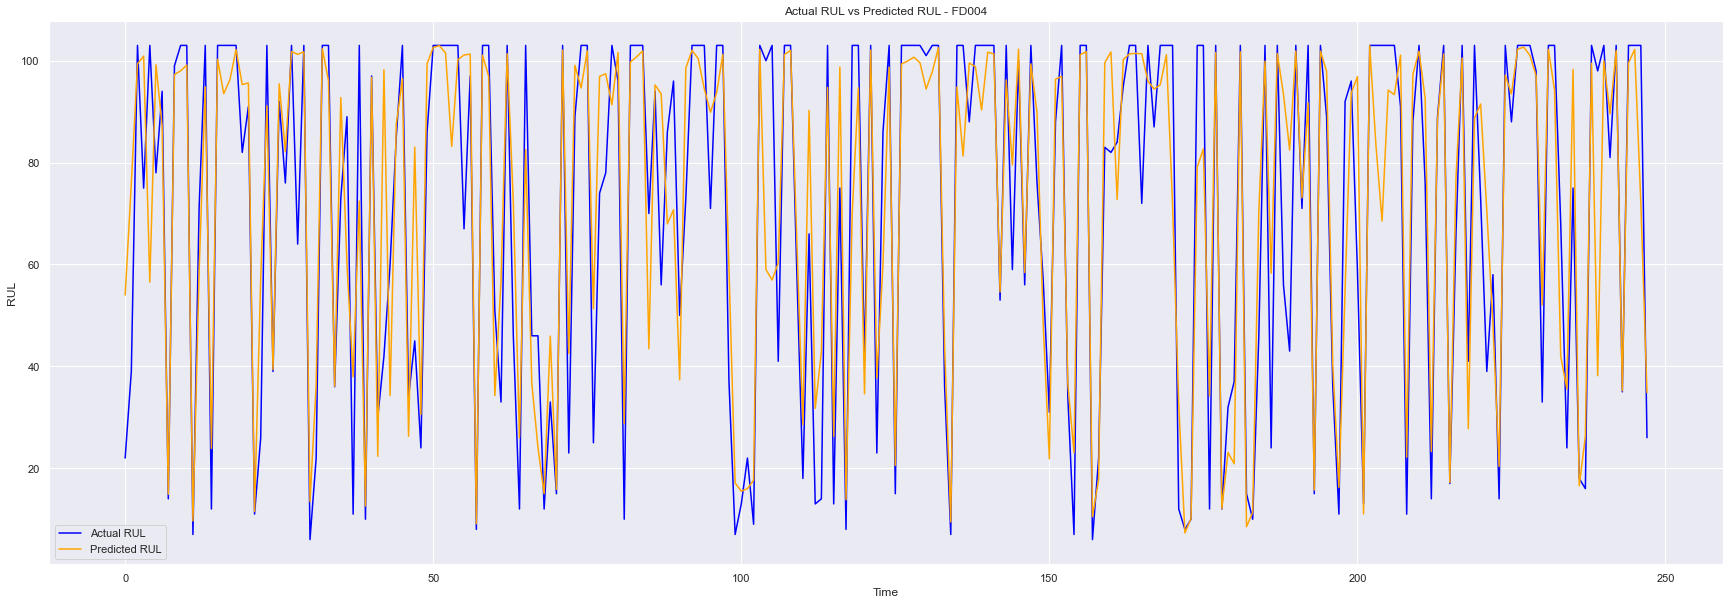

In [87]:

plt.figure(figsize=(30, 10))

# Line chart for actual RUL
plt.plot(y_test, label='Actual RUL', linestyle='-', color='blue')

# Line chart for predicted RUL
plt.plot(y_hat_test_rf, label='Predicted RUL', linestyle='-', color='orange')

plt.title('Actual RUL vs Predicted RUL - FD004')
plt.xlabel('Time')
plt.ylabel('RUL')
plt.legend()
plt.grid(True)
plt.show()


## Conclusion

In [88]:
Results

Model  RMSE-Train  R2-Train  RMSE-Test   R2-Test
0                    BiLSTM   14.932074  0.783170  16.819751  0.779448
1                    BiTRNN   14.498232  0.795587  16.630238  0.784390
2                     BiGRU   14.907611  0.783880  17.594899  0.758651
3                   ProgNet   14.954823  0.782509  17.049716  0.773376
4                      DCNN   14.163477  0.804917  16.648406  0.783919
5  Random Forest (Ensemble)   12.665646  0.843997  16.269244  0.793649